# **Medic Models**

PREPARACIÓN DEL DATASET

Se ha creado un primer dataset con la siguiente estructura:

  *   Alzheimer
  *   Escleros múltiple
  *   Glioma
  *   Meningioma
  *   Parkinson
  *   Pituitaria
  *   Sano



**MODELOS UTILIZADOS**


1.   RestNet50 -- *CNN Clásicas*
      *   Explicatividad con Grad-CAM ++
2.   DenseNet121 -- *CNN Clásicas*
      *   Explicatividad con Grad-CAM ++
3.   EfficientNetB0 -- *CNN Modernas*
      *   Explicatividad con Grad-CAM ++
4.   Med-Gemma -- *Modelos especializados*
      *   Explicatividad con Grad-CAM ++
5.   Nuu-Net -- *Modelos especializados*
      *   Explicatividad con Layer-CAM
6.   ConvNexTLarge -- *Arquitecturas modernas*
      *   Explicatividad con Layer-CAM
7.   ViT (en Keras o Pytorch+timm) -- *Transformers*
      *   Explicatividad con Attention Rollout



**CÓMPUTO UTILIZADO**

Para ejecutar los modelos, se ha creado un notebook de Google Colab y se ha ejecutado usando una GPU H200.

## ResNet50

In [ ]:
!pip install opencv-python
!pip install tensorflow
!pip install nvidia-cuda-nvcc-cu12

In [ ]:
# ----------------------------
# Importamos las librerías
# ----------------------------

import os
import io
import datetime
import numpy as np
import cv2
import matplotlib.pyplot as plt
import itertools

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, Callback

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

In [ ]:
devices = tf.config.get_visible_devices()
sel = [devices[i] for i in (0, 8)]
tf.config.set_visible_devices(sel)

In [ ]:
import tempfile
tf.config.get_visible_devices()
tempfile.gettempdir()

In [ ]:
# -------------------------------
# Configuración general
# -------------------------------
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 10
NUM_CLASSES = 7

RAD_WEIGHTS = "Models/RadImageNet-ResNet50_notop.h5"
CHECKPOINT_DIR = "checkpoints/checkpoints_resnet"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

DATA_DIR = "Data/dataset_resnet/"  # train/ val/ test/
# LOG_DIR="logs"
LOG_DIR = os.path.join("/home/jovyan/logs/logs_resnet", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(LOG_DIR, exist_ok=True)

In [ ]:
# ---------------------------------------------------------------
# Cargamos el TensorBoard para visualización del entrenamiento
# ---------------------------------------------------------------
#%reload_ext tensorboard
%load_ext tensorboard
%tensorboard --logdir $LOG_DIR


# ===============================
# DATA GENERATORS (shuffle explícito)
# ===============================
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

!rmdir 'Data/dataset_resnet/train/.ipynb_checkpoints'

train_gen = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)
# os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
!rmdir 'Data/dataset_resnet/test/.ipynb_checkpoints'
!rmdir 'Data/dataset_resnet/val/.ipynb_checkpoints'

val_gen = val_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "test"),
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)
print (train_gen.class_indices)

class_names = list(train_gen.class_indices.keys())

print("Clases detectadas:", class_names)

# ===============================
# LOAD RADIMAGENET RESNET50 (notop) y head nuevo
# ===============================
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights=None,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
print("Cargando pesos RadImageNet desde:", RAD_WEIGHTS)
base_model.load_weights(RAD_WEIGHTS)

# Congelar la mayoría de capas
for layer in base_model.layers[:-10]:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.3)(x)
output = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = models.Model(inputs=base_model.input, outputs=output)

# ===============================
# MÉTRICA F1 MACRO PERSONALIZADA (Keras Metric)
# ===============================
class F1Macro(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name="f1_macro", dtype=tf.float32, **kwargs):
        super().__init__(name=name, dtype=dtype, **kwargs)
        self.num_classes = num_classes
        self.eps = 1e-7
        # acumuladores
        self.tp = self.add_weight(name="tp", shape=(num_classes,), initializer="zeros", dtype=tf.float32)
        self.fp = self.add_weight(name="fp", shape=(num_classes,), initializer="zeros", dtype=tf.float32)
        self.fn = self.add_weight(name="fn", shape=(num_classes,), initializer="zeros", dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        y_true: one-hot (batch, C)
        y_pred: probabilities (batch, C)
        """
        y_true = tf.cast(y_true, tf.int32)
        # convertir a indices
        y_true_idx = tf.argmax(y_true, axis=1)
        y_pred_idx = tf.argmax(y_pred, axis=1)

        y_true_oh = tf.one_hot(y_true_idx, depth=self.num_classes)
        y_pred_oh = tf.one_hot(y_pred_idx, depth=self.num_classes)

        y_true_oh = tf.cast(y_true_oh, tf.float32)
        y_pred_oh = tf.cast(y_pred_oh, tf.float32)

        tp_batch = tf.reduce_sum(y_true_oh * y_pred_oh, axis=0)
        fp_batch = tf.reduce_sum((1 - y_true_oh) * y_pred_oh, axis=0)
        fn_batch = tf.reduce_sum(y_true_oh * (1 - y_pred_oh), axis=0)

        self.tp.assign_add(tp_batch)
        self.fp.assign_add(fp_batch)
        self.fn.assign_add(fn_batch)

    def result(self):
        precision = self.tp / (self.tp + self.fp + self.eps)
        recall = self.tp / (self.tp + self.fn + self.eps)
        f1_per_class = 2 * precision * recall / (precision + recall + self.eps)
        # media macro
        return tf.reduce_mean(f1_per_class)

    def reset_states(self):
        for v in (self.tp, self.fp, self.fn):
            v.assign(tf.zeros_like(v))


# ===============================
# COMPILAR MODELO
# ===============================
print(NUM_CLASSES)
f1_metric = F1Macro(num_classes=NUM_CLASSES)
# (mantenemos accuracy; el resto de métricas las calculamos en callback)
model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy", f1_metric]
)

model.summary()

# ===============================
# CALLBACKS (checkpoints, earlystop, tensorboard)
# ===============================
checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(CHECKPOINT_DIR, "epoch_{epoch:02d}_valacc_{val_accuracy:.2f}.h5"),
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

tensorboard_cb = TensorBoard(
    log_dir=LOG_DIR,
    histogram_freq=1,
    write_graph=True,
    write_images=True,

)

# ===============================
# CALLBACK: Matriz de confusión + classification_report en TensorBoard
# ===============================
class ConfusionMatrixAndReport(Callback):
    def __init__(self, val_gen, log_dir, class_names):
        super().__init__()
        self.val_gen = val_gen
        self.log_dir = log_dir
        self.class_names = class_names
        self.file_writer_cm = tf.summary.create_file_writer(os.path.join(log_dir, "confusion_matrix"))
        self.file_writer_reports = tf.summary.create_file_writer(os.path.join(log_dir, "reports"))

    def _plot_confusion_matrix(self, cm, epoch):
        fig = plt.figure(figsize=(8, 8))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(len(self.class_names))
        plt.xticks(tick_marks, self.class_names, rotation=45, ha='right')
        plt.yticks(tick_marks, self.class_names)

        fmt = "d"
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
        plt.ylabel("True label")
        plt.xlabel("Predicted label")
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        plt.close(fig)
        buf.seek(0)
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        image = tf.expand_dims(image, 0)
        return image

    def on_epoch_end(self, epoch, logs=None):
        # predecir sobre todo el conjunto de validación
        steps = int(np.ceil(self.val_gen.samples / float(self.val_gen.batch_size)))
        y_probs = self.model.predict(self.val_gen, steps=steps, verbose=0)
        y_pred = np.argmax(y_probs, axis=1)
        # true labels
        # DirectoryIterator tiene .classes con labels en orden
        y_true = self.val_gen.classes

        # confusion matrix
        cm = confusion_matrix(y_true, y_pred, labels=list(range(len(self.class_names))))

        # classification report
        report = classification_report(y_true, y_pred, target_names=self.class_names, output_dict=True, zero_division=0)
        # extraer macro averages
        precision_macro = report["macro avg"]["precision"]
        recall_macro = report["macro avg"]["recall"]
        f1_macro = report["macro avg"]["f1-score"]

        # log confusion matrix image
        cm_image = self._plot_confusion_matrix(cm, epoch)
        with self.file_writer_cm.as_default():
            tf.summary.image("ConfusionMatrix", cm_image, step=epoch)

        # log scalar summaries for macro metrics
        with self.file_writer_reports.as_default():
            tf.summary.scalar("val_precision_macro", precision_macro, step=epoch)
            tf.summary.scalar("val_recall_macro", recall_macro, step=epoch)
            tf.summary.scalar("val_f1_macro", f1_macro, step=epoch)

        # also print concise report to console
        print(f"\n--- Validation classification report (epoch {epoch+1}) ---")
        print(classification_report(y_true, y_pred, target_names=self.class_names, zero_division=0))

cm_cb = ConfusionMatrixAndReport(val_gen, LOG_DIR, class_names)

# ===============================
# CALLBACK: Grad-CAM images per epoch (small subset)
# ===============================
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv5_block3_out"):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        loss = preds[:, pred_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))
    conv = conv_outputs[0]
    cam = tf.reduce_sum(tf.multiply(pooled, conv), axis=-1)
    cam = tf.nn.relu(cam)
    cam = cam - tf.reduce_min(cam)
    cam = cam / (tf.reduce_max(cam) + 1e-9)
    return cam.numpy()

class GradCAMCallback(Callback):
    def __init__(self, val_gen, log_dir, class_names, num_images=3):
        super().__init__()
        self.val_gen = val_gen
        self.class_names = class_names
        self.num_images = min(num_images, self.val_gen.samples)
        self.file_writer = tf.summary.create_file_writer(os.path.join(log_dir, "gradcam"))

    def on_epoch_end(self, epoch, logs=None):
        # select indices evenly across validation set
        indices = np.linspace(0, self.val_gen.samples - 1, self.num_images, dtype=int)
        for i, idx in enumerate(indices):
            # compute which batch and offset
            batch_index = idx // self.val_gen.batch_size
            offset = idx % self.val_gen.batch_size
            # get that batch
            batch_x, batch_y = self.val_gen[batch_index]
            img = batch_x[offset]  # image normalized [0,1]
            inp = np.expand_dims(img, axis=0)
            preds = self.model.predict(inp, verbose=0)
            pred_idx = int(np.argmax(preds[0]))
            pred_name = self.class_names[pred_idx]
            prob = float(np.max(preds[0]))

            cam = make_gradcam_heatmap(inp, self.model)
            cam_resized = cv2.resize((cam * 255).astype(np.uint8), (IMG_SIZE[1], IMG_SIZE[0]))
            heatmap = cv2.applyColorMap(cam_resized, cv2.COLORMAP_JET)
            img_uint8 = (img * 255).astype(np.uint8)
            if img_uint8.ndim == 2:
                img_uint8 = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)
            overlay = cv2.addWeighted(img_uint8, 0.6, heatmap, 0.4, 0)
            overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
            overlay = np.expand_dims(overlay, axis=0)

            with self.file_writer.as_default():
                tf.summary.image(f"GradCAM_idx_{idx}_pred_{pred_name}_{prob:.2f}", overlay, step=epoch)

gradcam_cb = GradCAMCallback(val_gen, LOG_DIR, class_names, num_images=3)

# ===============================
# ENTRENAMIENTO
# ===============================
print("🚀 Iniciando fine-tuning...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb, cm_cb, gradcam_cb, tensorboard_cb]
)

# ===============================
# GUARDAR MODELO FINAL
# ===============================
model.save("ResNet50_RadImageNet_finetuned.h5")

# ===============================
# EVALUACIÓN FINAL EN TEST
# ===============================
print("\nEvaluando en test set...")
steps_test = int(np.ceil(test_gen.samples / float(test_gen.batch_size)))
y_probs_test = model.predict(test_gen, steps=steps_test, verbose=1)
y_pred_test = np.argmax(y_probs_test, axis=1)
y_true_test = test_gen.classes

print("\n--- Test classification report ---")
print(classification_report(y_true_test, y_pred_test, target_names=class_names, zero_division=0))

cm_test = confusion_matrix(y_true_test, y_pred_test, labels=list(range(len(class_names))))
print("\nConfusion matrix (test):")
print(cm_test)



Found 19307 images belonging to 7 classes.
Found 4141 images belonging to 7 classes.
Found 4141 images belonging to 7 classes.
{'alzheimer': 0, 'esclerosismultiple': 1, 'glioma': 2, 'meningioma': 3, 'parkinson': 4, 'pituitaria': 5, 'sano': 6}
Clases detectadas: ['alzheimer', 'esclerosismultiple', 'glioma', 'meningioma', 'parkinson', 'pituitaria', 'sano']
Cargando pesos RadImageNet desde: Models/RadImageNet-ResNet50_notop.h5
7


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,602,055 (90.03 MB)

 Trainable params: 4,480,007 (17.09 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

🚀 Iniciando fine-tuning...
Epoch 1/10
1161/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5104 - f1_macro: 0.5096 - loss: 1.2843

2026-01-09 22:31:41.864943: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5899', 4 bytes spill stores, 4 bytes spill loads

2026-01-09 22:31:41.993076: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5899', 12 bytes spill stores, 12 bytes spill loads



1206/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5144 - f1_macro: 0.5137 - loss: 1.2743

2026-01-09 22:31:55.162899: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1772', 4 bytes spill stores, 4 bytes spill loads




Epoch 1: val_accuracy improved from None to 0.75489, saving model to checkpoints/checkpoints_resnet/epoch_01_valacc_0.75.h5



Epoch 1: finished saving model to checkpoints/checkpoints_resnet/epoch_01_valacc_0.75.h5

--- Validation classification report (epoch 1) ---
                    precision    recall  f1-score   support

         alzheimer       0.88      0.96      0.92       481
esclerosismultiple       0.73      0.74      0.73       688
            glioma       0.78      0.76      0.77       617
        meningioma       0.65      0.49      0.56       546
         parkinson       0.74      0.85      0.79       680
        pituitaria       0.83      0.82      0.83       511
              sano       0.67      0.68      0.68       618

          accuracy                           0.75      4141
         macro avg       0.76      0.76      0.75      4141
      weighted avg       0.75      0.75      0.75      4141



/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_34']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 65s 44ms/step - accuracy: 0.6193 - f1_macro: 0.6213 - loss: 1.0097 - val_accuracy: 0.7549 - val_f1_macro: 0.7543 - val_loss: 0.6380
Epoch 2/10
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7442 - f1_macro: 0.7452 - loss: 0.6731
Epoch 2: val_accuracy improved from 0.75489 to 0.81140, saving model to checkpoints/checkpoints_resnet/epoch_02_valacc_0.81.h5



Epoch 2: finished saving model to checkpoints/checkpoints_resnet/epoch_02_valacc_0.81.h5

--- Validation classification report (epoch 2) ---
                    precision    recall  f1-score   support

         alzheimer       0.90      0.94      0.92       481
esclerosismultiple       0.84      0.76      0.80       688
            glioma       0.86      0.80      0.83       617
        meningioma       0.73      0.59      0.65       546
         parkinson       0.83      0.90      0.86       680
        pituitaria       0.80      0.95      0.87       511
              sano       0.72      0.75      0.73       618

          accuracy                           0.81      4141
         macro avg       0.81      0.81      0.81      4141
      weighted avg       0.81      0.81      0.81      4141



/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_34']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.7634 - f1_macro: 0.7646 - loss: 0.6298 - val_accuracy: 0.8114 - val_f1_macro: 0.8102 - val_loss: 0.5021
Epoch 3/10
1204/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8014 - f1_macro: 0.8021 - loss: 0.5374
Epoch 3: val_accuracy improved from 0.81140 to 0.82879, saving model to checkpoints/checkpoints_resnet/epoch_03_valacc_0.83.h5



Epoch 3: finished saving model to checkpoints/checkpoints_resnet/epoch_03_valacc_0.83.h5

--- Validation classification report (epoch 3) ---
                    precision    recall  f1-score   support

         alzheimer       0.87      0.98      0.92       481
esclerosismultiple       0.84      0.83      0.84       688
            glioma       0.82      0.84      0.83       617
        meningioma       0.77      0.59      0.67       546
         parkinson       0.89      0.89      0.89       680
        pituitaria       0.85      0.93      0.89       511
              sano       0.74      0.76      0.75       618

          accuracy                           0.83      4141
         macro avg       0.83      0.83      0.83      4141
      weighted avg       0.83      0.83      0.83      4141



/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_34']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.8119 - f1_macro: 0.8125 - loss: 0.5116 - val_accuracy: 0.8288 - val_f1_macro: 0.8263 - val_loss: 0.4417
Epoch 4/10
1206/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8317 - f1_macro: 0.8317 - loss: 0.4451
Epoch 4: val_accuracy improved from 0.82879 to 0.84931, saving model to checkpoints/checkpoints_resnet/epoch_04_valacc_0.85.h5



Epoch 4: finished saving model to checkpoints/checkpoints_resnet/epoch_04_valacc_0.85.h5

--- Validation classification report (epoch 4) ---
                    precision    recall  f1-score   support

         alzheimer       0.87      0.98      0.92       481
esclerosismultiple       0.87      0.82      0.84       688
            glioma       0.91      0.80      0.85       617
        meningioma       0.74      0.77      0.75       546
         parkinson       0.87      0.92      0.89       680
        pituitaria       0.89      0.94      0.91       511
              sano       0.80      0.75      0.78       618

          accuracy                           0.85      4141
         macro avg       0.85      0.85      0.85      4141
      weighted avg       0.85      0.85      0.85      4141



/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_34']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.8356 - f1_macro: 0.8355 - loss: 0.4397 - val_accuracy: 0.8493 - val_f1_macro: 0.8499 - val_loss: 0.3950
Epoch 5/10
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8498 - f1_macro: 0.8497 - loss: 0.3913
Epoch 5: val_accuracy improved from 0.84931 to 0.85631, saving model to checkpoints/checkpoints_resnet/epoch_05_valacc_0.86.h5



Epoch 5: finished saving model to checkpoints/checkpoints_resnet/epoch_05_valacc_0.86.h5

--- Validation classification report (epoch 5) ---
                    precision    recall  f1-score   support

         alzheimer       0.95      0.87      0.91       481
esclerosismultiple       0.84      0.88      0.86       688
            glioma       0.85      0.87      0.86       617
        meningioma       0.81      0.69      0.75       546
         parkinson       0.90      0.91      0.91       680
        pituitaria       0.89      0.94      0.91       511
              sano       0.78      0.83      0.80       618

          accuracy                           0.86      4141
         macro avg       0.86      0.85      0.86      4141
      weighted avg       0.86      0.86      0.86      4141



/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_34']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.8538 - f1_macro: 0.8535 - loss: 0.3848 - val_accuracy: 0.8563 - val_f1_macro: 0.8559 - val_loss: 0.3690
Epoch 6/10
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8715 - f1_macro: 0.8715 - loss: 0.3445
Epoch 6: val_accuracy improved from 0.85631 to 0.86791, saving model to checkpoints/checkpoints_resnet/epoch_06_valacc_0.87.h5



Epoch 6: finished saving model to checkpoints/checkpoints_resnet/epoch_06_valacc_0.87.h5

--- Validation classification report (epoch 6) ---
                    precision    recall  f1-score   support

         alzheimer       0.90      0.95      0.92       481
esclerosismultiple       0.88      0.87      0.88       688
            glioma       0.92      0.81      0.86       617
        meningioma       0.78      0.76      0.77       546
         parkinson       0.91      0.93      0.92       680
        pituitaria       0.87      0.95      0.91       511
              sano       0.82      0.82      0.82       618

          accuracy                           0.87      4141
         macro avg       0.87      0.87      0.87      4141
      weighted avg       0.87      0.87      0.87      4141



/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_34']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.8717 - f1_macro: 0.8713 - loss: 0.3408 - val_accuracy: 0.8679 - val_f1_macro: 0.8676 - val_loss: 0.3368
Epoch 7/10
1206/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8891 - f1_macro: 0.8879 - loss: 0.3018
Epoch 7: val_accuracy did not improve from 0.86791

--- Validation classification report (epoch 7) ---
                    precision    recall  f1-score   support

         alzheimer       0.99      0.81      0.89       481
esclerosismultiple       0.87      0.89      0.88       688
            glioma       0.92      0.80      0.86       617
        meningioma       0.72      0.86      0.79       546
         parkinson       0.92      0.93      0.92       680
        pituitaria       0.93      0.90      0.92       511
              sano       0.78      0.87      0.82       618

          accuracy                           0.87      4141
         macro avg       0.88      0.86      0.87      4141
      weighted avg      

/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_34']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.8899 - f1_macro: 0.8891 - loss: 0.2974 - val_accuracy: 0.8669 - val_f1_macro: 0.8681 - val_loss: 0.3435
Epoch 8/10
1206/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8973 - f1_macro: 0.8964 - loss: 0.2691
Epoch 8: val_accuracy improved from 0.86791 to 0.88046, saving model to checkpoints/checkpoints_resnet/epoch_08_valacc_0.88.h5



Epoch 8: finished saving model to checkpoints/checkpoints_resnet/epoch_08_valacc_0.88.h5

--- Validation classification report (epoch 8) ---
                    precision    recall  f1-score   support

         alzheimer       0.87      0.99      0.93       481
esclerosismultiple       0.90      0.86      0.88       688
            glioma       0.84      0.88      0.86       617
        meningioma       0.82      0.78      0.80       546
         parkinson       0.93      0.93      0.93       680
        pituitaria       0.91      0.95      0.93       511
              sano       0.87      0.79      0.83       618

          accuracy                           0.88      4141
         macro avg       0.88      0.88      0.88      4141
      weighted avg       0.88      0.88      0.88      4141



/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_34']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.8971 - f1_macro: 0.8963 - loss: 0.2694 - val_accuracy: 0.8805 - val_f1_macro: 0.8800 - val_loss: 0.3129
Epoch 9/10
1206/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9093 - f1_macro: 0.9086 - loss: 0.2418
Epoch 9: val_accuracy improved from 0.88046 to 0.88650, saving model to checkpoints/checkpoints_resnet/epoch_09_valacc_0.89.h5



Epoch 9: finished saving model to checkpoints/checkpoints_resnet/epoch_09_valacc_0.89.h5

--- Validation classification report (epoch 9) ---
                    precision    recall  f1-score   support

         alzheimer       0.88      0.97      0.92       481
esclerosismultiple       0.93      0.84      0.88       688
            glioma       0.94      0.84      0.89       617
        meningioma       0.81      0.82      0.82       546
         parkinson       0.94      0.94      0.94       680
        pituitaria       0.89      0.97      0.93       511
              sano       0.81      0.86      0.84       618

          accuracy                           0.89      4141
         macro avg       0.89      0.89      0.89      4141
      weighted avg       0.89      0.89      0.89      4141



/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_34']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - accuracy: 0.9117 - f1_macro: 0.9109 - loss: 0.2386 - val_accuracy: 0.8865 - val_f1_macro: 0.8868 - val_loss: 0.3064
Epoch 10/10
1204/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9134 - f1_macro: 0.9113 - loss: 0.2279
Epoch 10: val_accuracy improved from 0.88650 to 0.89278, saving model to checkpoints/checkpoints_resnet/epoch_10_valacc_0.89.h5



Epoch 10: finished saving model to checkpoints/checkpoints_resnet/epoch_10_valacc_0.89.h5

--- Validation classification report (epoch 10) ---
                    precision    recall  f1-score   support

         alzheimer       0.92      0.94      0.93       481
esclerosismultiple       0.92      0.85      0.89       688
            glioma       0.93      0.87      0.90       617
        meningioma       0.83      0.82      0.83       546
         parkinson       0.90      0.96      0.93       680
        pituitaria       0.91      0.95      0.93       511
              sano       0.85      0.86      0.85       618

          accuracy                           0.89      4141
         macro avg       0.89      0.89      0.89      4141
      weighted avg       0.89      0.89      0.89      4141



/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_34']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.9188 - f1_macro: 0.9176 - loss: 0.2163 - val_accuracy: 0.8928 - val_f1_macro: 0.8930 - val_loss: 0.2870



Evaluando en test set...
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step

--- Test classification report ---
                    precision    recall  f1-score   support

         alzheimer       0.93      0.94      0.93       480
esclerosismultiple       0.91      0.88      0.90       688
            glioma       0.95      0.87      0.90       617
        meningioma       0.86      0.83      0.84       546
         parkinson       0.92      0.96      0.94       681
        pituitaria       0.91      0.97      0.94       511
              sano       0.84      0.87      0.86       618

          accuracy                           0.90      4141
         macro avg       0.90      0.90      0.90      4141
      weighted avg       0.90      0.90      0.90      4141


Confusion matrix (test):
[[449   0   0   0   0   0  31]
 [  0 608   2   2  45   4  27]
 [  0   5 534  53   3   9  13]
 [  0   5  22 452   4  38  25]
 [  0  21   1   2 655   0   2]
 [  0   0   2  11   0 497   1]
 [ 36  30   3   5  

In [ ]:
import shutil

# Comprueba el directorio
print(LOG_DIR)

# (opcional) comprime los logs
shutil.make_archive("logs_tensorboard_resnet", "zip", LOG_DIR)

/home/jovyan/logs/logs_resnet/20260109-222006


'/home/jovyan/logs_tensorboard_resnet.zip'

# **DenseNet**

In [ ]:
import os
import io
import datetime
import numpy as np
import cv2
import matplotlib.pyplot as plt
import itertools

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, Callback

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

In [ ]:
# ===============================
# CONFIG
# ===============================
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 10
NUM_CLASSES = 7

RAD_WEIGHTS_DENSENET = "Models/RadImageNet-DenseNet121_notop.h5"
CHECKPOINT_DIR = "checkpoints/checkpoints_densenet"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)


DATA_DIR = "Data/dataset_densenet"  # train/ val/ test/
LOG_DIR = os.path.join("/home/jovyan/logs/logs_densenet", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(LOG_DIR, exist_ok=True)

In [ ]:
# ===============================
# DATA GENERATORS (shuffle explícito)
# ===============================
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_gen = val_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "test"),
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_gen.class_indices.keys())
print("Clases detectadas:", class_names)

# ===============================
# LOAD RADIMAGENET DENSENET121 (notop) y head nuevo
# ===============================
from tensorflow.keras.applications import DenseNet121

base_model = DenseNet121(
    include_top=False,
    weights=None,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
print("Cargando pesos RadImageNet DenseNet121 desde:", RAD_WEIGHTS_DENSENET)
base_model.load_weights(RAD_WEIGHTS_DENSENET)

# Congelar la mayoría de capas
for layer in base_model.layers[:-20]:  # descongelamos últimas 20 capas para fine-tuning
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.3)(x)
output = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = models.Model(inputs=base_model.input, outputs=output)

# ===============================
# MÉTRICA F1 MACRO PERSONALIZADA
# ===============================
class F1Macro(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name="f1_macro", dtype=tf.float32, **kwargs):
        super().__init__(name=name, dtype=dtype, **kwargs)
        self.num_classes = num_classes
        self.eps = 1e-7
        self.tp = self.add_weight(name="tp", shape=(num_classes,), initializer="zeros", dtype=tf.float32)
        self.fp = self.add_weight(name="fp", shape=(num_classes,), initializer="zeros", dtype=tf.float32)
        self.fn = self.add_weight(name="fn", shape=(num_classes,), initializer="zeros", dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.int32)
        y_true_idx = tf.argmax(y_true, axis=1)
        y_pred_idx = tf.argmax(y_pred, axis=1)

        y_true_oh = tf.cast(tf.one_hot(y_true_idx, depth=self.num_classes), tf.float32)
        y_pred_oh = tf.cast(tf.one_hot(y_pred_idx, depth=self.num_classes), tf.float32)

        tp_batch = tf.reduce_sum(y_true_oh * y_pred_oh, axis=0)
        fp_batch = tf.reduce_sum((1 - y_true_oh) * y_pred_oh, axis=0)
        fn_batch = tf.reduce_sum(y_true_oh * (1 - y_pred_oh), axis=0)

        self.tp.assign_add(tp_batch)
        self.fp.assign_add(fp_batch)
        self.fn.assign_add(fn_batch)

    def result(self):
        precision = self.tp / (self.tp + self.fp + self.eps)
        recall = self.tp / (self.tp + self.fn + self.eps)
        f1_per_class = 2 * precision * recall / (precision + recall + self.eps)
        return tf.reduce_mean(f1_per_class)

    def reset_states(self):
        for v in (self.tp, self.fp, self.fn):
            v.assign(tf.zeros_like(v))

# ===============================
# COMPILAR MODELO
# ===============================
f1_metric = F1Macro(num_classes=NUM_CLASSES)
model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy", f1_metric]
)

model.summary()

# ===============================
# CALLBACKS
# ===============================
checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(CHECKPOINT_DIR, "epoch_{epoch:02d}_valacc_{val_accuracy:.2f}.h5"),
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

tensorboard_cb = TensorBoard(
    log_dir=LOG_DIR,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='batch',
    profile_batch=0
)

# ===============================
# CALLBACK: Matriz de confusión + classification_report
# ===============================
class ConfusionMatrixAndReport(Callback):
    def __init__(self, val_gen, log_dir, class_names):
        super().__init__()
        self.val_gen = val_gen
        self.log_dir = log_dir
        self.class_names = class_names
        self.file_writer_cm = tf.summary.create_file_writer(os.path.join(log_dir, "confusion_matrix"))
        self.file_writer_reports = tf.summary.create_file_writer(os.path.join(log_dir, "reports"))

    def _plot_confusion_matrix(self, cm, epoch):
        fig = plt.figure(figsize=(8, 8))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(len(self.class_names))
        plt.xticks(tick_marks, self.class_names, rotation=45, ha='right')
        plt.yticks(tick_marks, self.class_names)
        fmt = "d"
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
        plt.ylabel("True label")
        plt.xlabel("Predicted label")
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        plt.close(fig)
        buf.seek(0)
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        image = tf.expand_dims(image, 0)
        return image

    def on_epoch_end(self, epoch, logs=None):
        steps = int(np.ceil(self.val_gen.samples / float(self.val_gen.batch_size)))
        y_probs = self.model.predict(self.val_gen, steps=steps, verbose=0)
        y_pred = np.argmax(y_probs, axis=1)
        y_true = self.val_gen.classes

        cm = confusion_matrix(y_true, y_pred, labels=list(range(len(self.class_names))))
        report = classification_report(y_true, y_pred, target_names=self.class_names, output_dict=True, zero_division=0)

        precision_macro = report["macro avg"]["precision"]
        recall_macro = report["macro avg"]["recall"]
        f1_macro = report["macro avg"]["f1-score"]

        cm_image = self._plot_confusion_matrix(cm, epoch)
        with self.file_writer_cm.as_default():
            tf.summary.image("ConfusionMatrix", cm_image, step=epoch)

        with self.file_writer_reports.as_default():
            tf.summary.scalar("val_precision_macro", precision_macro, step=epoch)
            tf.summary.scalar("val_recall_macro", recall_macro, step=epoch)
            tf.summary.scalar("val_f1_macro", f1_macro, step=epoch)

        print(f"\n--- Validation classification report (epoch {epoch+1}) ---")
        print(classification_report(y_true, y_pred, target_names=self.class_names, zero_division=0))

cm_cb = ConfusionMatrixAndReport(val_gen, LOG_DIR, class_names)

# ===============================
# CALLBACK: Grad-CAM
# ===============================
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv5_block16_concat"):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        loss = preds[:, pred_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))
    conv = conv_outputs[0]
    cam = tf.reduce_sum(tf.multiply(pooled, conv), axis=-1)
    cam = tf.nn.relu(cam)
    cam = cam - tf.reduce_min(cam)
    cam = cam / (tf.reduce_max(cam) + 1e-9)
    return cam.numpy()

class GradCAMCallback(Callback):
    def __init__(self, val_gen, log_dir, class_names, num_images=3):
        super().__init__()
        self.val_gen = val_gen
        self.class_names = class_names
        self.num_images = min(num_images, self.val_gen.samples)
        self.file_writer = tf.summary.create_file_writer(os.path.join(log_dir, "gradcam"))

    def on_epoch_end(self, epoch, logs=None):
        indices = np.linspace(0, self.val_gen.samples - 1, self.num_images, dtype=int)
        for i, idx in enumerate(indices):
            batch_index = idx // self.val_gen.batch_size
            offset = idx % self.val_gen.batch_size
            batch_x, batch_y = self.val_gen[batch_index]
            img = batch_x[offset]
            inp = np.expand_dims(img, axis=0)
            preds = self.model.predict(inp, verbose=0)
            pred_idx = int(np.argmax(preds[0]))
            pred_name = self.class_names[pred_idx]
            prob = float(np.max(preds[0]))

            cam = make_gradcam_heatmap(inp, self.model)
            cam_resized = cv2.resize((cam * 255).astype(np.uint8), (IMG_SIZE[1], IMG_SIZE[0]))
            heatmap = cv2.applyColorMap(cam_resized, cv2.COLORMAP_JET)
            img_uint8 = (img * 255).astype(np.uint8)
            if img_uint8.ndim == 2:
                img_uint8 = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)
            overlay = cv2.addWeighted(img_uint8, 0.6, heatmap, 0.4, 0)
            overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
            overlay = np.expand_dims(overlay, axis=0)

            with self.file_writer.as_default():
                tf.summary.image(f"GradCAM_idx_{idx}_pred_{pred_name}_{prob:.2f}", overlay, step=epoch)

gradcam_cb = GradCAMCallback(val_gen, LOG_DIR, class_names, num_images=3)

# ===============================
# ENTRENAMIENTO
# ===============================
print("🚀 Iniciando fine-tuning DenseNet121...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb, tensorboard_cb, cm_cb, gradcam_cb]
)

# ===============================
# GUARDAR MODELO FINAL
# ===============================
model.save("DenseNet121_RadImageNet_finetuned.h5")

# ===============================
# EVALUACIÓN FINAL EN TEST
# ===============================
print("\nEvaluando en test set...")
steps_test = int(np.ceil(test_gen.samples / float(test_gen.batch_size)))
y_probs_test = model.predict(test_gen, steps=steps_test, verbose=1)
y_pred_test = np.argmax(y_probs_test, axis=1)
y_true_test = test_gen.classes

print("\n--- Test classification report ---")
print(classification_report(y_true_test, y_pred_test, target_names=class_names, zero_division=0))

cm_test = confusion_matrix(y_true_test, y_pred_test, labels=list(range(len(class_names))))
print("\nConfusion matrix (test):")
print(cm_test)



Found 19307 images belonging to 7 classes.
Found 4141 images belonging to 7 classes.
Found 4141 images belonging to 7 classes.
Clases detectadas: ['alzheimer', 'esclerosismultiple', 'glioma', 'meningioma', 'parkinson', 'pituitaria', 'sano']
Cargando pesos RadImageNet DenseNet121 desde: Models/RadImageNet-DenseNet121_notop.h5


Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,044,679 (26.87 MB)

 Trainable params: 374,343 (1.43 MB)

 Non-trainable params: 6,670,336 (25.45 MB)

🚀 Iniciando fine-tuning DenseNet121...
Epoch 1/10
 914/1207 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.4153 - f1_macro: 0.3988 - loss: 1.5819

2026-01-09 23:01:00.420496: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12286', 4 bytes spill stores, 4 bytes spill loads

2026-01-09 23:01:00.553125: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12286', 12 bytes spill stores, 12 bytes spill loads



1204/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4405 - f1_macro: 0.4259 - loss: 1.5265

2026-01-09 23:01:37.337405: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3378', 4 bytes spill stores, 4 bytes spill loads




Epoch 1: val_accuracy improved from None to 0.65588, saving model to checkpoints/checkpoints_densenet/epoch_01_valacc_0.66.h5



Epoch 1: finished saving model to checkpoints/checkpoints_densenet/epoch_01_valacc_0.66.h5

--- Validation classification report (epoch 1) ---
                    precision    recall  f1-score   support

         alzheimer       0.81      1.00      0.90       481
esclerosismultiple       0.69      0.58      0.63       688
            glioma       0.66      0.70      0.68       617
        meningioma       0.53      0.35      0.42       546
         parkinson       0.61      0.70      0.65       680
        pituitaria       0.65      0.85      0.74       511
              sano       0.60      0.50      0.55       618

          accuracy                           0.66      4141
         macro avg       0.65      0.67      0.65      4141
      weighted avg       0.65      0.66      0.64      4141



/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_670']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 142s 94ms/step - accuracy: 0.5319 - f1_macro: 0.5242 - loss: 1.3196 - val_accuracy: 0.6559 - val_f1_macro: 0.6507 - val_loss: 0.9753
Epoch 2/10
1205/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6336 - f1_macro: 0.6343 - loss: 1.0131
Epoch 2: val_accuracy improved from 0.65588 to 0.72060, saving model to checkpoints/checkpoints_densenet/epoch_02_valacc_0.72.h5



Epoch 2: finished saving model to checkpoints/checkpoints_densenet/epoch_02_valacc_0.72.h5

--- Validation classification report (epoch 2) ---
                    precision    recall  f1-score   support

         alzheimer       0.84      0.99      0.91       481
esclerosismultiple       0.71      0.68      0.69       688
            glioma       0.73      0.73      0.73       617
        meningioma       0.62      0.52      0.56       546
         parkinson       0.71      0.73      0.72       680
        pituitaria       0.74      0.87      0.80       511
              sano       0.68      0.60      0.64       618

          accuracy                           0.72      4141
         macro avg       0.72      0.73      0.72      4141
      weighted avg       0.71      0.72      0.72      4141



/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_670']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 0.6495 - f1_macro: 0.6505 - loss: 0.9633 - val_accuracy: 0.7206 - val_f1_macro: 0.7212 - val_loss: 0.7811
Epoch 3/10
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6883 - f1_macro: 0.6910 - loss: 0.8395
Epoch 3: val_accuracy improved from 0.72060 to 0.75755, saving model to checkpoints/checkpoints_densenet/epoch_03_valacc_0.76.h5



Epoch 3: finished saving model to checkpoints/checkpoints_densenet/epoch_03_valacc_0.76.h5

--- Validation classification report (epoch 3) ---
                    precision    recall  f1-score   support

         alzheimer       0.86      0.98      0.92       481
esclerosismultiple       0.72      0.77      0.74       688
            glioma       0.82      0.71      0.76       617
        meningioma       0.65      0.59      0.62       546
         parkinson       0.74      0.78      0.76       680
        pituitaria       0.77      0.90      0.83       511
              sano       0.75      0.61      0.68       618

          accuracy                           0.76      4141
         macro avg       0.76      0.76      0.76      4141
      weighted avg       0.76      0.76      0.75      4141



/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_670']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 0.6947 - f1_macro: 0.6967 - loss: 0.8228 - val_accuracy: 0.7575 - val_f1_macro: 0.7585 - val_loss: 0.6745
Epoch 4/10
1205/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7261 - f1_macro: 0.7285 - loss: 0.7535
Epoch 4: val_accuracy improved from 0.75755 to 0.77662, saving model to checkpoints/checkpoints_densenet/epoch_04_valacc_0.78.h5



Epoch 4: finished saving model to checkpoints/checkpoints_densenet/epoch_04_valacc_0.78.h5

--- Validation classification report (epoch 4) ---
                    precision    recall  f1-score   support

         alzheimer       0.86      0.98      0.92       481
esclerosismultiple       0.79      0.72      0.75       688
            glioma       0.78      0.80      0.79       617
        meningioma       0.69      0.56      0.61       546
         parkinson       0.76      0.84      0.80       680
        pituitaria       0.81      0.90      0.85       511
              sano       0.73      0.68      0.71       618

          accuracy                           0.78      4141
         macro avg       0.77      0.78      0.78      4141
      weighted avg       0.77      0.78      0.77      4141



/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_670']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 0.7289 - f1_macro: 0.7312 - loss: 0.7373 - val_accuracy: 0.7766 - val_f1_macro: 0.7761 - val_loss: 0.6045
Epoch 5/10
1206/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7493 - f1_macro: 0.7515 - loss: 0.6844
Epoch 5: val_accuracy improved from 0.77662 to 0.79836, saving model to checkpoints/checkpoints_densenet/epoch_05_valacc_0.80.h5



Epoch 5: finished saving model to checkpoints/checkpoints_densenet/epoch_05_valacc_0.80.h5

--- Validation classification report (epoch 5) ---
                    precision    recall  f1-score   support

         alzheimer       0.87      0.96      0.92       481
esclerosismultiple       0.81      0.75      0.78       688
            glioma       0.85      0.77      0.81       617
        meningioma       0.68      0.65      0.66       546
         parkinson       0.81      0.85      0.83       680
        pituitaria       0.82      0.93      0.87       511
              sano       0.74      0.72      0.73       618

          accuracy                           0.80      4141
         macro avg       0.80      0.80      0.80      4141
      weighted avg       0.80      0.80      0.80      4141



/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_670']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 0.7540 - f1_macro: 0.7564 - loss: 0.6728 - val_accuracy: 0.7984 - val_f1_macro: 0.7995 - val_loss: 0.5476
Epoch 6/10
1205/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7707 - f1_macro: 0.7726 - loss: 0.6195
Epoch 6: val_accuracy improved from 0.79836 to 0.80560, saving model to checkpoints/checkpoints_densenet/epoch_06_valacc_0.81.h5



Epoch 6: finished saving model to checkpoints/checkpoints_densenet/epoch_06_valacc_0.81.h5

--- Validation classification report (epoch 6) ---
                    precision    recall  f1-score   support

         alzheimer       0.87      0.97      0.92       481
esclerosismultiple       0.86      0.72      0.78       688
            glioma       0.84      0.80      0.82       617
        meningioma       0.74      0.59      0.66       546
         parkinson       0.80      0.90      0.85       680
        pituitaria       0.81      0.94      0.87       511
              sano       0.73      0.76      0.74       618

          accuracy                           0.81      4141
         macro avg       0.81      0.81      0.80      4141
      weighted avg       0.81      0.81      0.80      4141



/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_670']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.7718 - f1_macro: 0.7733 - loss: 0.6146 - val_accuracy: 0.8056 - val_f1_macro: 0.8044 - val_loss: 0.5099
Epoch 7/10
1205/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7914 - f1_macro: 0.7915 - loss: 0.5720
Epoch 7: val_accuracy improved from 0.80560 to 0.82806, saving model to checkpoints/checkpoints_densenet/epoch_07_valacc_0.83.h5



Epoch 7: finished saving model to checkpoints/checkpoints_densenet/epoch_07_valacc_0.83.h5

--- Validation classification report (epoch 7) ---
                    precision    recall  f1-score   support

         alzheimer       0.86      0.98      0.92       481
esclerosismultiple       0.85      0.80      0.82       688
            glioma       0.89      0.80      0.84       617
        meningioma       0.71      0.69      0.70       546
         parkinson       0.86      0.89      0.88       680
        pituitaria       0.83      0.94      0.88       511
              sano       0.78      0.72      0.75       618

          accuracy                           0.83      4141
         macro avg       0.83      0.83      0.83      4141
      weighted avg       0.83      0.83      0.83      4141



/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_670']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 0.7926 - f1_macro: 0.7932 - loss: 0.5684 - val_accuracy: 0.8281 - val_f1_macro: 0.8276 - val_loss: 0.4684
Epoch 8/10
1206/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8033 - f1_macro: 0.8046 - loss: 0.5379
Epoch 8: val_accuracy improved from 0.82806 to 0.83700, saving model to checkpoints/checkpoints_densenet/epoch_08_valacc_0.84.h5



Epoch 8: finished saving model to checkpoints/checkpoints_densenet/epoch_08_valacc_0.84.h5

--- Validation classification report (epoch 8) ---
                    precision    recall  f1-score   support

         alzheimer       0.88      0.96      0.92       481
esclerosismultiple       0.84      0.83      0.84       688
            glioma       0.89      0.80      0.85       617
        meningioma       0.73      0.68      0.70       546
         parkinson       0.91      0.87      0.89       680
        pituitaria       0.83      0.96      0.89       511
              sano       0.77      0.78      0.77       618

          accuracy                           0.84      4141
         macro avg       0.84      0.84      0.84      4141
      weighted avg       0.84      0.84      0.84      4141



/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_670']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 0.8046 - f1_macro: 0.8051 - loss: 0.5305 - val_accuracy: 0.8370 - val_f1_macro: 0.8368 - val_loss: 0.4400
Epoch 9/10
1206/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8132 - f1_macro: 0.8124 - loss: 0.4994
Epoch 9: val_accuracy improved from 0.83700 to 0.84569, saving model to checkpoints/checkpoints_densenet/epoch_09_valacc_0.85.h5



Epoch 9: finished saving model to checkpoints/checkpoints_densenet/epoch_09_valacc_0.85.h5

--- Validation classification report (epoch 9) ---
                    precision    recall  f1-score   support

         alzheimer       0.90      0.93      0.91       481
esclerosismultiple       0.85      0.85      0.85       688
            glioma       0.87      0.84      0.85       617
        meningioma       0.78      0.67      0.72       546
         parkinson       0.91      0.88      0.89       680
        pituitaria       0.85      0.95      0.90       511
              sano       0.77      0.81      0.79       618

          accuracy                           0.85      4141
         macro avg       0.84      0.85      0.84      4141
      weighted avg       0.85      0.85      0.84      4141



/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_670']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 34s 28ms/step - accuracy: 0.8158 - f1_macro: 0.8160 - loss: 0.4979 - val_accuracy: 0.8457 - val_f1_macro: 0.8448 - val_loss: 0.4143
Epoch 10/10
1205/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8263 - f1_macro: 0.8261 - loss: 0.4738
Epoch 10: val_accuracy improved from 0.84569 to 0.85149, saving model to checkpoints/checkpoints_densenet/epoch_10_valacc_0.85.h5



Epoch 10: finished saving model to checkpoints/checkpoints_densenet/epoch_10_valacc_0.85.h5

--- Validation classification report (epoch 10) ---
                    precision    recall  f1-score   support

         alzheimer       0.88      0.95      0.92       481
esclerosismultiple       0.87      0.87      0.87       688
            glioma       0.89      0.83      0.86       617
        meningioma       0.75      0.70      0.72       546
         parkinson       0.89      0.91      0.90       680
        pituitaria       0.85      0.95      0.90       511
              sano       0.81      0.76      0.79       618

          accuracy                           0.85      4141
         macro avg       0.85      0.85      0.85      4141
      weighted avg       0.85      0.85      0.85      4141



/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_670']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 0.8265 - f1_macro: 0.8263 - loss: 0.4724 - val_accuracy: 0.8515 - val_f1_macro: 0.8501 - val_loss: 0.3919



Evaluando en test set...
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step

--- Test classification report ---
                    precision    recall  f1-score   support

         alzheimer       0.88      0.95      0.91       480
esclerosismultiple       0.87      0.88      0.87       688
            glioma       0.91      0.83      0.87       617
        meningioma       0.76      0.73      0.74       546
         parkinson       0.90      0.91      0.91       681
        pituitaria       0.85      0.93      0.89       511
              sano       0.82      0.79      0.80       618

          accuracy                           0.86      4141
         macro avg       0.85      0.86      0.86      4141
      weighted avg       0.86      0.86      0.86      4141


Confusion matrix (test):
[[454   0   0   0   0   0  26]
 [  0 604   4  10  37   1  32]
 [  0   9 511  70   7   9  11]
 [  1  10  29 396   4  75  31]
 [  0  46   2   3 620   2   8]
 [  0   0   8  26   1 475   1]
 [ 58  24   9  19  

In [ ]:
import shutil

# Comprueba el directorio
print(LOG_DIR)

shutil.make_archive("logs_tensorboard_densenet", "zip", LOG_DIR)
# (opcional) comprime los logs

/home/jovyan/logs/logs_densenet/20260109-225656


'/home/jovyan/logs_tensorboard_densenet.zip'

## --- EfficientNet ---

In [ ]:
import os
import io
import datetime
import numpy as np
import cv2
import matplotlib.pyplot as plt
import itertools

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, Callback

from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# ===============================
# CONFIG
# ===============================
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 10
NUM_CLASSES = 7

CHECKPOINT_DIR = "checkpoints/checkpoints_efficientnet"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

DATA_DIR = "Data/dataset_efficientnet"  # train/ val/ test/
LOG_DIR = os.path.join("/home/jovyan/logs/logs_efficientnet", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(LOG_DIR, exist_ok=True)

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input
# ===============================
# DATA GENERATORS
# ===============================
#train_datagen = ImageDataGenerator(rescale=1.0/255)
#val_datagen = ImageDataGenerator(rescale=1.0/255)
#test_datagen = ImageDataGenerator(rescale=1.0/255)
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_gen = val_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "test"),
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_gen.class_indices.keys())
print("Clases detectadas:", class_names)

# ===============================
# LOAD EfficientNetB0 pre-trained on ImageNet
# ===============================
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',  # pesos preentrenados en ImageNet
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Congelar la mayoría de capas
for layer in base_model.layers[:-20]:  # fine-tuning últimas 20 capas
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.3)(x)
output = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = models.Model(inputs=base_model.input, outputs=output)

# ===============================
# MÉTRICA F1 MACRO PERSONALIZADA
# ===============================
class F1Macro(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name="f1_macro", dtype=tf.float32, **kwargs):
        super().__init__(name=name, dtype=dtype, **kwargs)
        self.num_classes = num_classes
        self.eps = 1e-7
        self.tp = self.add_weight(name="tp", shape=(num_classes,), initializer="zeros", dtype=tf.float32)
        self.fp = self.add_weight(name="fp", shape=(num_classes,), initializer="zeros", dtype=tf.float32)
        self.fn = self.add_weight(name="fn", shape=(num_classes,), initializer="zeros", dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_idx = tf.argmax(tf.cast(y_true, tf.int32), axis=1)
        y_pred_idx = tf.argmax(y_pred, axis=1)
        y_true_oh = tf.cast(tf.one_hot(y_true_idx, depth=self.num_classes), tf.float32)
        y_pred_oh = tf.cast(tf.one_hot(y_pred_idx, depth=self.num_classes), tf.float32)
        tp_batch = tf.reduce_sum(y_true_oh * y_pred_oh, axis=0)
        fp_batch = tf.reduce_sum((1 - y_true_oh) * y_pred_oh, axis=0)
        fn_batch = tf.reduce_sum(y_true_oh * (1 - y_pred_oh), axis=0)
        self.tp.assign_add(tp_batch)
        self.fp.assign_add(fp_batch)
        self.fn.assign_add(fn_batch)

    def result(self):
        precision = self.tp / (self.tp + self.fp + self.eps)
        recall = self.tp / (self.tp + self.fn + self.eps)
        f1_per_class = 2 * precision * recall / (precision + recall + self.eps)
        return tf.reduce_mean(f1_per_class)

    def reset_states(self):
        for v in (self.tp, self.fp, self.fn):
            v.assign(tf.zeros_like(v))

# ===============================
# COMPILAR MODELO
# ===============================
f1_metric = F1Macro(num_classes=NUM_CLASSES)
model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy", f1_metric]
)

model.summary()

# ===============================
# CALLBACKS
# ===============================
checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(CHECKPOINT_DIR, "epoch_{epoch:02d}_valacc_{val_accuracy:.2f}.h5"),
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

tensorboard_cb = TensorBoard(
    log_dir=LOG_DIR,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='batch',
    profile_batch=0
)

# ===============================
# CALLBACK: Matriz de confusión + classification_report
# ===============================
class ConfusionMatrixAndReport(Callback):
    def __init__(self, val_gen, log_dir, class_names):
        super().__init__()
        self.val_gen = val_gen
        self.log_dir = log_dir
        self.class_names = class_names
        self.file_writer_cm = tf.summary.create_file_writer(os.path.join(log_dir, "confusion_matrix"))
        self.file_writer_reports = tf.summary.create_file_writer(os.path.join(log_dir, "reports"))

    def _plot_confusion_matrix(self, cm, epoch):
        fig = plt.figure(figsize=(8, 8))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(len(self.class_names))
        plt.xticks(tick_marks, self.class_names, rotation=45, ha='right')
        plt.yticks(tick_marks, self.class_names)
        fmt = "d"
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
        plt.ylabel("True label")
        plt.xlabel("Predicted label")
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        plt.close(fig)
        buf.seek(0)
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        image = tf.expand_dims(image, 0)
        return image

    def on_epoch_end(self, epoch, logs=None):
        steps = int(np.ceil(self.val_gen.samples / float(self.val_gen.batch_size)))
        y_probs = self.model.predict(self.val_gen, steps=steps, verbose=0)
        y_pred = np.argmax(y_probs, axis=1)
        y_true = self.val_gen.classes

        cm = confusion_matrix(y_true, y_pred, labels=list(range(len(self.class_names))))
        report = classification_report(y_true, y_pred, target_names=self.class_names, output_dict=True, zero_division=0)

        precision_macro = report["macro avg"]["precision"]
        recall_macro = report["macro avg"]["recall"]
        f1_macro = report["macro avg"]["f1-score"]

        cm_image = self._plot_confusion_matrix(cm, epoch)
        with self.file_writer_cm.as_default():
            tf.summary.image("ConfusionMatrix", cm_image, step=epoch)

        with self.file_writer_reports.as_default():
            tf.summary.scalar("val_precision_macro", precision_macro, step=epoch)
            tf.summary.scalar("val_recall_macro", recall_macro, step=epoch)
            tf.summary.scalar("val_f1_macro", f1_macro, step=epoch)

        print(f"\n--- Validation classification report (epoch {epoch+1}) ---")
        print(classification_report(y_true, y_pred, target_names=self.class_names, zero_division=0))

cm_cb = ConfusionMatrixAndReport(val_gen, LOG_DIR, class_names)

# ===============================
# CALLBACK: Grad-CAM
# ===============================
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="top_conv"):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        loss = preds[:, pred_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))
    conv = conv_outputs[0]
    cam = tf.reduce_sum(tf.multiply(pooled, conv), axis=-1)
    cam = tf.nn.relu(cam)
    cam = cam - tf.reduce_min(cam)
    cam = cam / (tf.reduce_max(cam) + 1e-9)
    return cam.numpy()

class GradCAMCallback(Callback):
    def __init__(self, val_gen, log_dir, class_names, num_images=3):
        super().__init__()
        self.val_gen = val_gen
        self.class_names = class_names
        self.num_images = min(num_images, self.val_gen.samples)
        self.file_writer = tf.summary.create_file_writer(os.path.join(log_dir, "gradcam"))

    def on_epoch_end(self, epoch, logs=None):
        indices = np.linspace(0, self.val_gen.samples - 1, self.num_images, dtype=int)
        for i, idx in enumerate(indices):
            batch_index = idx // self.val_gen.batch_size
            offset = idx % self.val_gen.batch_size
            batch_x, batch_y = self.val_gen[batch_index]
            img = batch_x[offset]
            inp = np.expand_dims(img, axis=0)
            preds = self.model.predict(inp, verbose=0)
            pred_idx = int(np.argmax(preds[0]))
            pred_name = self.class_names[pred_idx]
            prob = float(np.max(preds[0]))

            cam = make_gradcam_heatmap(inp, self.model)
            cam_resized = cv2.resize((cam * 255).astype(np.uint8), (IMG_SIZE[1], IMG_SIZE[0]))
            heatmap = cv2.applyColorMap(cam_resized, cv2.COLORMAP_JET)
            img_uint8 = (img * 255).astype(np.uint8)
            if img_uint8.ndim == 2:
                img_uint8 = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)
            overlay = cv2.addWeighted(img_uint8, 0.6, heatmap, 0.4, 0)
            overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
            overlay = np.expand_dims(overlay, axis=0)

            with self.file_writer.as_default():
                tf.summary.image(f"GradCAM_idx_{idx}_pred_{pred_name}_{prob:.2f}", overlay, step=epoch)

gradcam_cb = GradCAMCallback(val_gen, LOG_DIR, class_names, num_images=3)

# ===============================
# ENTRENAMIENTO
# ===============================
print("🚀 Iniciando fine-tuning EfficientNetB0...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb, tensorboard_cb, cm_cb, gradcam_cb]
)

# ===============================
# GUARDAR MODELO FINAL
# ===============================
model.save("EfficientNetB0_ImageNet_finetuned.h5")

# ===============================
# EVALUACIÓN FINAL EN TEST
# ===============================
print("\nEvaluando en test set...")
steps_test = int(np.ceil(test_gen.samples / float(test_gen.batch_size)))
y_probs_test = model.predict(test_gen, steps=steps_test, verbose=1)
y_pred_test = np.argmax(y_probs_test, axis=1)
y_true_test = test_gen.classes

print("\n--- Test classification report ---")
print(classification_report(y_true_test, y_pred_test, target_names=class_names, zero_division=0))

cm_test = confusion_matrix(y_true_test, y_pred_test, labels=list(range(len(class_names))))
print("\nConfusion matrix (test):")
print(cm_test)


Found 19307 images belonging to 7 classes.
Found 4141 images belonging to 7 classes.
Found 4141 images belonging to 7 classes.
Clases detectadas: ['alzheimer', 'esclerosismultiple', 'glioma', 'meningioma', 'parkinson', 'pituitaria', 'sano']


Model: "functional_66"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,058,538 (15.48 MB)

 Trainable params: 1,359,927 (5.19 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

🚀 Iniciando fine-tuning EfficientNetB0...
Epoch 1/10


2026-01-10 06:58:37.049598: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-10 06:58:37.164074: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-10 06:58:39.305528: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-10 06:58:39.428127: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-10 06:58:40.216776: E external/local_xla/xla/stream_

 314/1207 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.5603 - f1_macro: 0.5501 - loss: 1.2436

2026-01-10 06:58:55.286069: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11163', 4 bytes spill stores, 4 bytes spill loads

2026-01-10 06:58:55.391412: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11163', 4 bytes spill stores, 4 bytes spill loads

2026-01-10 06:59:02.361951: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-10 06:59:02.475759: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-10 06:59:02.588738: E external/local_xla/xla

1206/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7173 - f1_macro: 0.7127 - loss: 0.8129

2026-01-10 06:59:38.049670: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2120', 4 bytes spill stores, 4 bytes spill loads

2026-01-10 06:59:44.379765: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-10 06:59:44.493957: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-10 06:59:46.298009: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-10 06:59:46.414013: E external/local_xla/xla/stre


Epoch 1: val_accuracy improved from None to 0.92586, saving model to checkpoints/checkpoints_efficientnet/epoch_01_valacc_0.93.h5



Epoch 1: finished saving model to checkpoints/checkpoints_efficientnet/epoch_01_valacc_0.93.h5

--- Validation classification report (epoch 1) ---
                    precision    recall  f1-score   support

         alzheimer       0.90      0.95      0.93       481
esclerosismultiple       0.95      0.91      0.93       688
            glioma       0.92      0.93      0.92       617
        meningioma       0.88      0.88      0.88       546
         parkinson       0.99      0.99      0.99       680
        pituitaria       0.96      0.96      0.96       511
              sano       0.87      0.86      0.87       618

          accuracy                           0.93      4141
         macro avg       0.92      0.93      0.92      4141
      weighted avg       0.93      0.93      0.93      4141



2026-01-10 07:00:12.800063: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-10 07:00:12.912210: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-10 07:00:13.026782: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-10 07:00:13.150034: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-10 07:00:14.094023: E external/local_xla/xla/stream_

1207/1207 ━━━━━━━━━━━━━━━━━━━━ 120s 76ms/step - accuracy: 0.8163 - f1_macro: 0.8151 - loss: 0.5288 - val_accuracy: 0.9259 - val_f1_macro: 0.9249 - val_loss: 0.2002
Epoch 2/10
1206/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9095 - f1_macro: 0.9088 - loss: 0.2636
Epoch 2: val_accuracy improved from 0.92586 to 0.94301, saving model to checkpoints/checkpoints_efficientnet/epoch_02_valacc_0.94.h5



Epoch 2: finished saving model to checkpoints/checkpoints_efficientnet/epoch_02_valacc_0.94.h5

--- Validation classification report (epoch 2) ---
                    precision    recall  f1-score   support

         alzheimer       0.95      0.88      0.91       481
esclerosismultiple       0.98      0.94      0.96       688
            glioma       0.96      0.94      0.95       617
        meningioma       0.92      0.93      0.93       546
         parkinson       0.99      1.00      0.99       680
        pituitaria       0.95      0.99      0.97       511
              sano       0.85      0.93      0.89       618

          accuracy                           0.94      4141
         macro avg       0.94      0.94      0.94      4141
      weighted avg       0.94      0.94      0.94      4141



/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_1369']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.9165 - f1_macro: 0.9159 - loss: 0.2388 - val_accuracy: 0.9430 - val_f1_macro: 0.9417 - val_loss: 0.1445
Epoch 3/10
1205/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9428 - f1_macro: 0.9421 - loss: 0.1672
Epoch 3: val_accuracy improved from 0.94301 to 0.95291, saving model to checkpoints/checkpoints_efficientnet/epoch_03_valacc_0.95.h5



Epoch 3: finished saving model to checkpoints/checkpoints_efficientnet/epoch_03_valacc_0.95.h5

--- Validation classification report (epoch 3) ---
                    precision    recall  f1-score   support

         alzheimer       0.93      0.94      0.93       481
esclerosismultiple       0.95      0.98      0.96       688
            glioma       0.94      0.98      0.96       617
        meningioma       0.98      0.89      0.93       546
         parkinson       0.99      1.00      0.99       680
        pituitaria       0.95      0.99      0.97       511
              sano       0.93      0.88      0.91       618

          accuracy                           0.95      4141
         macro avg       0.95      0.95      0.95      4141
      weighted avg       0.95      0.95      0.95      4141



/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_1369']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.9446 - f1_macro: 0.9440 - loss: 0.1608 - val_accuracy: 0.9529 - val_f1_macro: 0.9512 - val_loss: 0.1249
Epoch 4/10
1205/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9512 - f1_macro: 0.9503 - loss: 0.1338
Epoch 4: val_accuracy improved from 0.95291 to 0.96064, saving model to checkpoints/checkpoints_efficientnet/epoch_04_valacc_0.96.h5



Epoch 4: finished saving model to checkpoints/checkpoints_efficientnet/epoch_04_valacc_0.96.h5

--- Validation classification report (epoch 4) ---
                    precision    recall  f1-score   support

         alzheimer       0.90      0.99      0.94       481
esclerosismultiple       0.99      0.94      0.97       688
            glioma       0.96      0.97      0.96       617
        meningioma       0.95      0.95      0.95       546
         parkinson       1.00      1.00      1.00       680
        pituitaria       0.99      0.98      0.98       511
              sano       0.93      0.90      0.91       618

          accuracy                           0.96      4141
         macro avg       0.96      0.96      0.96      4141
      weighted avg       0.96      0.96      0.96      4141



/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_1369']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.9531 - f1_macro: 0.9525 - loss: 0.1304 - val_accuracy: 0.9606 - val_f1_macro: 0.9598 - val_loss: 0.1007
Epoch 5/10
1205/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9631 - f1_macro: 0.9622 - loss: 0.1031
Epoch 5: val_accuracy improved from 0.96064 to 0.96426, saving model to checkpoints/checkpoints_efficientnet/epoch_05_valacc_0.96.h5



Epoch 5: finished saving model to checkpoints/checkpoints_efficientnet/epoch_05_valacc_0.96.h5

--- Validation classification report (epoch 5) ---
                    precision    recall  f1-score   support

         alzheimer       0.96      0.93      0.94       481
esclerosismultiple       0.99      0.95      0.97       688
            glioma       0.97      0.97      0.97       617
        meningioma       0.97      0.95      0.96       546
         parkinson       1.00      1.00      1.00       680
        pituitaria       0.96      0.99      0.98       511
              sano       0.89      0.96      0.92       618

          accuracy                           0.96      4141
         macro avg       0.96      0.96      0.96      4141
      weighted avg       0.97      0.96      0.96      4141



/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_1369']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.9623 - f1_macro: 0.9618 - loss: 0.1042 - val_accuracy: 0.9643 - val_f1_macro: 0.9635 - val_loss: 0.0992
Epoch 6/10
1204/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9650 - f1_macro: 0.9641 - loss: 0.0942
Epoch 6: val_accuracy improved from 0.96426 to 0.97006, saving model to checkpoints/checkpoints_efficientnet/epoch_06_valacc_0.97.h5



Epoch 6: finished saving model to checkpoints/checkpoints_efficientnet/epoch_06_valacc_0.97.h5

--- Validation classification report (epoch 6) ---
                    precision    recall  f1-score   support

         alzheimer       0.94      0.97      0.95       481
esclerosismultiple       0.99      0.95      0.97       688
            glioma       0.99      0.97      0.98       617
        meningioma       0.97      0.97      0.97       546
         parkinson       1.00      1.00      1.00       680
        pituitaria       0.98      1.00      0.99       511
              sano       0.92      0.94      0.93       618

          accuracy                           0.97      4141
         macro avg       0.97      0.97      0.97      4141
      weighted avg       0.97      0.97      0.97      4141



/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_1369']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.9678 - f1_macro: 0.9673 - loss: 0.0900 - val_accuracy: 0.9701 - val_f1_macro: 0.9695 - val_loss: 0.0887
Epoch 7/10
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9746 - f1_macro: 0.9737 - loss: 0.0701
Epoch 7: val_accuracy did not improve from 0.97006

--- Validation classification report (epoch 7) ---
                    precision    recall  f1-score   support

         alzheimer       0.90      0.99      0.94       481
esclerosismultiple       0.98      0.98      0.98       688
            glioma       0.96      0.99      0.98       617
        meningioma       0.98      0.95      0.96       546
         parkinson       1.00      1.00      1.00       680
        pituitaria       0.98      0.99      0.99       511
              sano       0.97      0.89      0.93       618

          accuracy                           0.97      4141
         macro avg       0.97      0.97      0.97      4141
      weighted avg      

/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_1369']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.9737 - f1_macro: 0.9730 - loss: 0.0730 - val_accuracy: 0.9688 - val_f1_macro: 0.9677 - val_loss: 0.0823
Epoch 8/10
1203/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9763 - f1_macro: 0.9751 - loss: 0.0658
Epoch 8: val_accuracy improved from 0.97006 to 0.97319, saving model to checkpoints/checkpoints_efficientnet/epoch_08_valacc_0.97.h5



Epoch 8: finished saving model to checkpoints/checkpoints_efficientnet/epoch_08_valacc_0.97.h5

--- Validation classification report (epoch 8) ---
                    precision    recall  f1-score   support

         alzheimer       0.94      0.97      0.95       481
esclerosismultiple       0.96      0.98      0.97       688
            glioma       0.98      0.99      0.98       617
        meningioma       0.98      0.98      0.98       546
         parkinson       1.00      1.00      1.00       680
        pituitaria       0.99      0.99      0.99       511
              sano       0.96      0.91      0.93       618

          accuracy                           0.97      4141
         macro avg       0.97      0.97      0.97      4141
      weighted avg       0.97      0.97      0.97      4141



/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_1369']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.9771 - f1_macro: 0.9764 - loss: 0.0638 - val_accuracy: 0.9732 - val_f1_macro: 0.9726 - val_loss: 0.0725
Epoch 9/10
1205/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9803 - f1_macro: 0.9798 - loss: 0.0579
Epoch 9: val_accuracy improved from 0.97319 to 0.97537, saving model to checkpoints/checkpoints_efficientnet/epoch_09_valacc_0.98.h5



Epoch 9: finished saving model to checkpoints/checkpoints_efficientnet/epoch_09_valacc_0.98.h5

--- Validation classification report (epoch 9) ---
                    precision    recall  f1-score   support

         alzheimer       0.93      0.99      0.96       481
esclerosismultiple       0.97      0.98      0.98       688
            glioma       0.98      0.98      0.98       617
        meningioma       0.98      0.98      0.98       546
         parkinson       1.00      1.00      1.00       680
        pituitaria       0.99      0.99      0.99       511
              sano       0.97      0.91      0.94       618

          accuracy                           0.98      4141
         macro avg       0.97      0.98      0.97      4141
      weighted avg       0.98      0.98      0.98      4141



/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_1369']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.9803 - f1_macro: 0.9798 - loss: 0.0580 - val_accuracy: 0.9754 - val_f1_macro: 0.9746 - val_loss: 0.0725
Epoch 10/10
1203/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9828 - f1_macro: 0.9821 - loss: 0.0492
Epoch 10: val_accuracy did not improve from 0.97537

--- Validation classification report (epoch 10) ---
                    precision    recall  f1-score   support

         alzheimer       0.97      0.95      0.96       481
esclerosismultiple       0.99      0.97      0.98       688
            glioma       0.97      0.99      0.98       617
        meningioma       0.99      0.96      0.97       546
         parkinson       1.00      1.00      1.00       680
        pituitaria       0.98      0.99      0.99       511
              sano       0.94      0.96      0.95       618

          accuracy                           0.98      4141
         macro avg       0.98      0.97      0.97      4141
      weighted avg   

/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_1369']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1207/1207 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.9827 - f1_macro: 0.9821 - loss: 0.0498 - val_accuracy: 0.9754 - val_f1_macro: 0.9747 - val_loss: 0.0760



Evaluando en test set...
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step

--- Test classification report ---
                    precision    recall  f1-score   support

         alzheimer       0.95      0.97      0.96       480
esclerosismultiple       0.98      0.99      0.98       688
            glioma       0.99      0.97      0.98       617
        meningioma       0.96      0.99      0.98       546
         parkinson       1.00      1.00      1.00       681
        pituitaria       0.99      0.99      0.99       511
              sano       0.96      0.94      0.95       618

          accuracy                           0.98      4141
         macro avg       0.98      0.98      0.98      4141
      weighted avg       0.98      0.98      0.98      4141


Confusion matrix (test):
[[466   0   0   0   0   0  14]
 [  0 678   0   1   0   0   9]
 [  0   0 600  16   0   1   0]
 [  0   0   3 541   0   2   0]
 [  0   1   0   1 678   0   1]
 [  0   0   1   4   0 506   0]
 [ 23  12   1   0  

In [ ]:
import shutil

# Comprueba el directorio
print(LOG_DIR)

# (opcional) comprime los logs
shutil.make_archive("logs_tensorboard_efficientnet", "zip", LOG_DIR)

/home/jovyan/logs/logs_efficientnet/20260106-151617


'/home/jovyan/logs_tensorboard_efficientnet.zip'

# **ConvNeXTLarge**

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    ReduceLROnPlateau,
    EarlyStopping,
    CSVLogger
)
from tensorflow.keras import mixed_precision
# from tensorflow.keras.applications import ConvNeXtLarge
# from tensorflow.keras.applications.convnext import preprocess_input
from tensorflow.keras.applications.convnext import ConvNeXtLarge, preprocess_input

from sklearn.metrics import classification_report, confusion_matrix


In [ ]:

# ------------------------------------------------------------------
# CONFIGURACIÓN BÁSICA
# ------------------------------------------------------------------

DATA_DIR = "Data/dataset_convnextlarge"
IMG_SIZE = (224, 224)
NUM_CLASSES = 7

# Con H200 yo probaría 64 o 128 de batch sin miedo
BATCH_SIZE = 64

EPOCHS_PHASE1 = 5    # solo cabeza
EPOCHS_PHASE2 = 20   # fine-tuning
NUM_CAM_IMAGES = 3  # imágenes de validación para Layer-CAM

LOG_DIR = os.path.join("logs_convnextlarge", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(LOG_DIR, exist_ok=True)
CHECKPOINT_DIR = os.path.join(LOG_DIR, "checkpoints")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [ ]:
# ------------------------------------------------------------------
# MIXED PRECISION (para aprovechar la H200)
# ------------------------------------------------------------------

policy = mixed_precision.Policy("mixed_float16")
mixed_precision.set_global_policy(policy)
print("Mixed precision policy:", mixed_precision.global_policy())

Mixed precision policy: <DTypePolicy "mixed_float16">


In [ ]:
# ------------------------------------------------------------------
# GENERADORES DE DATOS
# ------------------------------------------------------------------

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_gen = val_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "test"),
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

class_indices = train_gen.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}
print("Clases:", class_indices)


Found 19307 images belonging to 7 classes.
Found 4141 images belonging to 7 classes.
Found 4141 images belonging to 7 classes.
Clases: {'alzheimer': 0, 'esclerosismultiple': 1, 'glioma': 2, 'meningioma': 3, 'parkinson': 4, 'pituitaria': 5, 'sano': 6}


In [ ]:
# ===============================
# MÉTRICA F1 MACRO PERSONALIZADA (Keras Metric)
# ===============================
class F1Macro(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name="f1_macro", dtype=tf.float32, **kwargs):
        super().__init__(name=name, dtype=dtype, **kwargs)
        self.num_classes = num_classes
        self.eps = 1e-7
        # acumuladores
        self.tp = self.add_weight(name="tp", shape=(num_classes,), initializer="zeros", dtype=tf.float32)
        self.fp = self.add_weight(name="fp", shape=(num_classes,), initializer="zeros", dtype=tf.float32)
        self.fn = self.add_weight(name="fn", shape=(num_classes,), initializer="zeros", dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        y_true: one-hot (batch, C)
        y_pred: probabilities (batch, C)
        """
        y_true = tf.cast(y_true, tf.int32)
        # convertir a indices
        y_true_idx = tf.argmax(y_true, axis=1)
        y_pred_idx = tf.argmax(y_pred, axis=1)

        y_true_oh = tf.one_hot(y_true_idx, depth=self.num_classes)
        y_pred_oh = tf.one_hot(y_pred_idx, depth=self.num_classes)

        y_true_oh = tf.cast(y_true_oh, tf.float32)
        y_pred_oh = tf.cast(y_pred_oh, tf.float32)

        tp_batch = tf.reduce_sum(y_true_oh * y_pred_oh, axis=0)
        fp_batch = tf.reduce_sum((1 - y_true_oh) * y_pred_oh, axis=0)
        fn_batch = tf.reduce_sum(y_true_oh * (1 - y_pred_oh), axis=0)

        self.tp.assign_add(tp_batch)
        self.fp.assign_add(fp_batch)
        self.fn.assign_add(fn_batch)

    def result(self):
        precision = self.tp / (self.tp + self.fp + self.eps)
        recall = self.tp / (self.tp + self.fn + self.eps)
        f1_per_class = 2 * precision * recall / (precision + recall + self.eps)
        # media macro
        return tf.reduce_mean(f1_per_class)

    def reset_states(self):
        for v in (self.tp, self.fp, self.fn):
            v.assign(tf.zeros_like(v))




f1_metric = F1Macro(num_classes=NUM_CLASSES)

In [ ]:
# ------------------------------------------------------------------
# MODELO ConvNeXtLarge
# ------------------------------------------------------------------

base_model = ConvNeXtLarge(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.4)(x)
# Importante: la última capa debe ser float32 para la pérdida en mixed precision
output = layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)

model = models.Model(inputs=base_model.input, outputs=output)

In [ ]:
# ===============================
# CALLBACK LAYER-CAM
# ===============================
class LayerCAMCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_gen, class_names, log_dir, num_images=3):
        super().__init__()
        self.val_gen = val_gen
        self.class_names = class_names
        self.num_images = min(num_images, val_gen.samples)
        self.writer = tf.summary.create_file_writer(os.path.join(log_dir, "layer_cam"))

    def on_train_begin(self, logs=None):
        # Buscar última capa Conv2D
        self.target_layer_name = None
        for layer in reversed(self.model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                shape = layer.output_shape
                if shape[1] > 1 and shape[2] > 1:
                    self.target_layer_name = layer.name
                    break
        if self.target_layer_name is None:
            raise ValueError("No se encontró capa Conv2D para Layer-CAM")
        self.layercam_model = tf.keras.models.Model(
            inputs=self.model.input,
            outputs=[self.model.get_layer(self.target_layer_name).output, self.model.output]
        )

    def layer_cam(self, img_array, class_index):
        with tf.GradientTape() as tape:
            conv_outputs, preds = self.layercam_model(img_array)
            loss = preds[:, class_index]
        grads = tape.gradient(loss, conv_outputs)
        conv_outputs = conv_outputs[0]
        grads = grads[0]
        cam = tf.nn.relu(grads) * conv_outputs
        cam = tf.reduce_sum(cam, axis=-1)
        cam = tf.nn.relu(cam)
        cam = cam / (tf.reduce_max(cam) + 1e-8)
        return cam.numpy()

    def overlay_layercam(self, img, cam, alpha=0.4):
        cam = tf.image.resize(cam[..., np.newaxis], img.shape[:2])
        cam = tf.squeeze(cam)
        heatmap = plt.cm.jet(cam.numpy())[:, :, :3]
        overlay = (1 - alpha) * img + alpha * heatmap
        return np.clip(overlay, 0, 1)

    def on_epoch_end(self, epoch, logs=None):
        indices = np.linspace(0, self.val_gen.samples - 1, self.num_images, dtype=int)
        for idx in indices:
            batch_index = idx // self.val_gen.batch_size
            offset = idx % self.val_gen.batch_size
            batch_x, batch_y = self.val_gen[batch_index]
            img = batch_x[offset]
            inp = np.expand_dims(img, axis=0)
            preds = self.model.predict(inp, verbose=0)
            pred_idx = int(np.argmax(preds[0]))
            pred_name = self.class_names[pred_idx]
            cam = self.layer_cam(inp, pred_idx)
            overlay = self.overlay_layercam(img, cam)
            overlay = np.expand_dims(overlay, 0)
            with self.writer.as_default():
                tf.summary.image(f"LayerCAM_idx_{idx}_pred_{pred_name}", overlay, step=epoch)
        self.writer.flush()

layercam_cb = LayerCAMCallback(val_gen, list(idx_to_class.values()), LOG_DIR, NUM_CAM_IMAGES)


In [ ]:
# ------------------------------------------------------------------
# CALLBACKS
# ------------------------------------------------------------------

os.makedirs("checkpoints/convnext_large", exist_ok=True)

checkpoint_cb = ModelCheckpoint(
    "checkpoints/convnext_large/epoch_{epoch:02d}_valacc_{val_accuracy:.2f}.h5",
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stopping_cb = EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True,
    verbose=1
)

tensorboard_cb = TensorBoard(
    log_dir=LOG_DIR,
    histogram_freq=1,
    write_graph=True,
    write_images=True,

)

csv_logger_cb = CSVLogger("training_convnext_large.log")

callbacks = [checkpoint_cb, reduce_lr_cb, early_stopping_cb, csv_logger_cb, tensorboard_cb]


In [ ]:
# ------------------------------------------------------------------
# FASE 1: ENTRENAR SOLO LA CABEZA
# ------------------------------------------------------------------

for layer in base_model.layers:
    layer.trainable = False

optimizer_phase1 = optimizers.Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer_phase1,
    loss="categorical_crossentropy",
    metrics=["accuracy", f1_metric]
)

print("\n=== Fase 1: entrenando solo la cabeza ===\n")
history_phase1 = model.fit(
    train_gen,
    epochs=EPOCHS_PHASE1,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1
)



=== Fase 1: entrenando solo la cabeza ===

Epoch 1/5


2026-01-12 08:36:16.103627: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 92 bytes spill stores, 92 bytes spill loads

2026-01-12 08:36:20.823972: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 08:36:20.937624: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 08:36:22.044407: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 08:36:22.160143: E external/local_xla/xla/stream_

277/302 ━━━━━━━━━━━━━━━━━━━━ 9s 398ms/step - accuracy: 0.6233 - f1_macro: 0.6229 - loss: 1.0065 

2026-01-12 08:38:24.978645: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 88 bytes spill stores, 88 bytes spill loads

2026-01-12 08:38:27.504182: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 08:38:27.617107: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 08:38:28.719506: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 08:38:28.841222: E external/local_xla/xla/stream_

302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.6333 - f1_macro: 0.6329 - loss: 0.9806

2026-01-12 08:38:58.367413: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 88 bytes spill stores, 88 bytes spill loads

2026-01-12 08:39:02.082102: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 08:39:02.202984: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 08:39:02.327201: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 08:39:02.440624: E external/local_xla/xla/stream_


Epoch 1: val_accuracy improved from None to 0.84545, saving model to checkpoints/convnext_large/epoch_01_valacc_0.85.h5



Epoch 1: finished saving model to checkpoints/convnext_large/epoch_01_valacc_0.85.h5
302/302 ━━━━━━━━━━━━━━━━━━━━ 227s 665ms/step - accuracy: 0.7478 - f1_macro: 0.7469 - loss: 0.6832 - val_accuracy: 0.8454 - val_f1_macro: 0.8431 - val_loss: 0.4097 - learning_rate: 0.0010
Epoch 2/5
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.8397 - f1_macro: 0.8395 - loss: 0.4341
Epoch 2: val_accuracy improved from 0.84545 to 0.85221, saving model to checkpoints/convnext_large/epoch_02_valacc_0.85.h5



Epoch 2: finished saving model to checkpoints/convnext_large/epoch_02_valacc_0.85.h5
302/302 ━━━━━━━━━━━━━━━━━━━━ 163s 541ms/step - accuracy: 0.8492 - f1_macro: 0.8478 - loss: 0.4066 - val_accuracy: 0.8522 - val_f1_macro: 0.8474 - val_loss: 0.3766 - learning_rate: 0.0010
Epoch 3/5
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.8713 - f1_macro: 0.8687 - loss: 0.3527
Epoch 3: val_accuracy improved from 0.85221 to 0.85511, saving model to checkpoints/convnext_large/epoch_03_valacc_0.86.h5



Epoch 3: finished saving model to checkpoints/convnext_large/epoch_03_valacc_0.86.h5
302/302 ━━━━━━━━━━━━━━━━━━━━ 164s 542ms/step - accuracy: 0.8731 - f1_macro: 0.8718 - loss: 0.3460 - val_accuracy: 0.8551 - val_f1_macro: 0.8508 - val_loss: 0.3674 - learning_rate: 0.0010
Epoch 4/5
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8747 - f1_macro: 0.8738 - loss: 0.3288
Epoch 4: val_accuracy improved from 0.85511 to 0.88143, saving model to checkpoints/convnext_large/epoch_04_valacc_0.88.h5



Epoch 4: finished saving model to checkpoints/convnext_large/epoch_04_valacc_0.88.h5
302/302 ━━━━━━━━━━━━━━━━━━━━ 162s 537ms/step - accuracy: 0.8771 - f1_macro: 0.8760 - loss: 0.3260 - val_accuracy: 0.8814 - val_f1_macro: 0.8781 - val_loss: 0.3053 - learning_rate: 0.0010
Epoch 5/5
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.8880 - f1_macro: 0.8862 - loss: 0.3020
Epoch 5: val_accuracy improved from 0.88143 to 0.88384, saving model to checkpoints/convnext_large/epoch_05_valacc_0.88.h5



Epoch 5: finished saving model to checkpoints/convnext_large/epoch_05_valacc_0.88.h5
302/302 ━━━━━━━━━━━━━━━━━━━━ 163s 539ms/step - accuracy: 0.8854 - f1_macro: 0.8839 - loss: 0.3048 - val_accuracy: 0.8838 - val_f1_macro: 0.8821 - val_loss: 0.2969 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.


In [ ]:
# ------------------------------------------------------------------
# FASE 2: FINE-TUNING (DESCONGELAR PARTE DEL BACKBONE)
# ------------------------------------------------------------------

# Descongelar p.ej. el último tercio de capas
n_layers = len(base_model.layers)
for layer in base_model.layers[int(n_layers * 2 / 3):]:
    layer.trainable = True

# Ajustar este LR si hay inestabilidad
optimizer_phase2 = optimizers.Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer_phase2,
    loss="categorical_crossentropy",
    metrics=["accuracy", f1_metric]
)

print("\n=== Fase 2: fine-tuning de las últimas capas ===\n")
history_phase2 = model.fit(
    train_gen,
    epochs=EPOCHS_PHASE2,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1
)



=== Fase 2: fine-tuning de las últimas capas ===

Epoch 1/20


2026-01-12 08:51:05.667137: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_48', 12 bytes spill stores, 12 bytes spill loads

2026-01-12 08:51:10.965841: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 08:51:11.087598: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 08:51:12.090918: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng1{k2=0,k3=0} for conv (f16[1,7,7,1536]{3,2,1,0}, u8[0]{0}) custom-call(f16[1,7,7,98304]{3,2,1,0}, f16[1536,7,7,64]{3,2,1,0}), window={size=7x7 pad=3_3x3_3}, dim_labels=b01f_o01i->b01f

265/302 ━━━━━━━━━━━━━━━━━━━━ 14s 400ms/step - accuracy: 0.8982 - f1_macro: 0.8955 - loss: 0.2783

2026-01-12 08:53:19.645977: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_48', 48 bytes spill stores, 48 bytes spill loads

2026-01-12 08:53:22.548169: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 08:53:22.676992: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 08:53:22.850660: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 08:53:22.993009: E external/local_xla/xla/stre

302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.9014 - f1_macro: 0.8979 - loss: 0.2693
Epoch 1: val_accuracy improved from 0.88384 to 0.94905, saving model to checkpoints/convnext_large/epoch_01_valacc_0.95.h5



Epoch 1: finished saving model to checkpoints/convnext_large/epoch_01_valacc_0.95.h5
302/302 ━━━━━━━━━━━━━━━━━━━━ 243s 669ms/step - accuracy: 0.9260 - f1_macro: 0.9174 - loss: 0.1997 - val_accuracy: 0.9490 - val_f1_macro: 0.9485 - val_loss: 0.1294 - learning_rate: 1.0000e-04
Epoch 2/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9626 - f1_macro: 0.9621 - loss: 0.0978
Epoch 2: val_accuracy improved from 0.94905 to 0.96040, saving model to checkpoints/convnext_large/epoch_02_valacc_0.96.h5



Epoch 2: finished saving model to checkpoints/convnext_large/epoch_02_valacc_0.96.h5
302/302 ━━━━━━━━━━━━━━━━━━━━ 165s 546ms/step - accuracy: 0.9658 - f1_macro: 0.9649 - loss: 0.0878 - val_accuracy: 0.9604 - val_f1_macro: 0.9601 - val_loss: 0.1169 - learning_rate: 1.0000e-04
Epoch 3/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9756 - f1_macro: 0.9747 - loss: 0.0634
Epoch 3: val_accuracy improved from 0.96040 to 0.96498, saving model to checkpoints/convnext_large/epoch_03_valacc_0.96.h5



Epoch 3: finished saving model to checkpoints/convnext_large/epoch_03_valacc_0.96.h5
302/302 ━━━━━━━━━━━━━━━━━━━━ 164s 542ms/step - accuracy: 0.9775 - f1_macro: 0.9768 - loss: 0.0583 - val_accuracy: 0.9650 - val_f1_macro: 0.9650 - val_loss: 0.0947 - learning_rate: 1.0000e-04
Epoch 4/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.9844 - f1_macro: 0.9834 - loss: 0.0397
Epoch 4: val_accuracy improved from 0.96498 to 0.96571, saving model to checkpoints/convnext_large/epoch_04_valacc_0.97.h5



Epoch 4: finished saving model to checkpoints/convnext_large/epoch_04_valacc_0.97.h5
302/302 ━━━━━━━━━━━━━━━━━━━━ 163s 539ms/step - accuracy: 0.9840 - f1_macro: 0.9832 - loss: 0.0430 - val_accuracy: 0.9657 - val_f1_macro: 0.9651 - val_loss: 0.0956 - learning_rate: 1.0000e-04
Epoch 5/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9887 - f1_macro: 0.9880 - loss: 0.0301
Epoch 5: val_accuracy improved from 0.96571 to 0.97078, saving model to checkpoints/convnext_large/epoch_05_valacc_0.97.h5



Epoch 5: finished saving model to checkpoints/convnext_large/epoch_05_valacc_0.97.h5
302/302 ━━━━━━━━━━━━━━━━━━━━ 163s 541ms/step - accuracy: 0.9874 - f1_macro: 0.9869 - loss: 0.0334 - val_accuracy: 0.9708 - val_f1_macro: 0.9698 - val_loss: 0.0978 - learning_rate: 1.0000e-04
Epoch 6/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9905 - f1_macro: 0.9900 - loss: 0.0265
Epoch 6: val_accuracy improved from 0.97078 to 0.97706, saving model to checkpoints/convnext_large/epoch_06_valacc_0.98.h5



Epoch 6: finished saving model to checkpoints/convnext_large/epoch_06_valacc_0.98.h5
302/302 ━━━━━━━━━━━━━━━━━━━━ 163s 539ms/step - accuracy: 0.9885 - f1_macro: 0.9881 - loss: 0.0316 - val_accuracy: 0.9771 - val_f1_macro: 0.9770 - val_loss: 0.0819 - learning_rate: 1.0000e-04
Epoch 7/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.9934 - f1_macro: 0.9932 - loss: 0.0187
Epoch 7: val_accuracy improved from 0.97706 to 0.97827, saving model to checkpoints/convnext_large/epoch_07_valacc_0.98.h5



Epoch 7: finished saving model to checkpoints/convnext_large/epoch_07_valacc_0.98.h5
302/302 ━━━━━━━━━━━━━━━━━━━━ 164s 541ms/step - accuracy: 0.9937 - f1_macro: 0.9934 - loss: 0.0182 - val_accuracy: 0.9783 - val_f1_macro: 0.9780 - val_loss: 0.0653 - learning_rate: 1.0000e-04
Epoch 8/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9927 - f1_macro: 0.9925 - loss: 0.0206
Epoch 8: val_accuracy did not improve from 0.97827
302/302 ━━━━━━━━━━━━━━━━━━━━ 162s 535ms/step - accuracy: 0.9923 - f1_macro: 0.9922 - loss: 0.0221 - val_accuracy: 0.9744 - val_f1_macro: 0.9735 - val_loss: 0.0835 - learning_rate: 1.0000e-04
Epoch 9/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9962 - f1_macro: 0.9960 - loss: 0.0122
Epoch 9: val_accuracy improved from 0.97827 to 0.97899, saving model to checkpoints/convnext_large/epoch_09_valacc_0.98.h5



Epoch 9: finished saving model to checkpoints/convnext_large/epoch_09_valacc_0.98.h5
302/302 ━━━━━━━━━━━━━━━━━━━━ 162s 535ms/step - accuracy: 0.9959 - f1_macro: 0.9957 - loss: 0.0129 - val_accuracy: 0.9790 - val_f1_macro: 0.9781 - val_loss: 0.0774 - learning_rate: 1.0000e-04
Epoch 10/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9964 - f1_macro: 0.9963 - loss: 0.0108
Epoch 10: val_accuracy improved from 0.97899 to 0.97947, saving model to checkpoints/convnext_large/epoch_10_valacc_0.98.h5



Epoch 10: finished saving model to checkpoints/convnext_large/epoch_10_valacc_0.98.h5

Epoch 10: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
302/302 ━━━━━━━━━━━━━━━━━━━━ 164s 542ms/step - accuracy: 0.9964 - f1_macro: 0.9962 - loss: 0.0115 - val_accuracy: 0.9795 - val_f1_macro: 0.9788 - val_loss: 0.0893 - learning_rate: 1.0000e-04
Epoch 11/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9978 - f1_macro: 0.9977 - loss: 0.0061
Epoch 11: val_accuracy improved from 0.97947 to 0.98672, saving model to checkpoints/convnext_large/epoch_11_valacc_0.99.h5



Epoch 11: finished saving model to checkpoints/convnext_large/epoch_11_valacc_0.99.h5
302/302 ━━━━━━━━━━━━━━━━━━━━ 163s 540ms/step - accuracy: 0.9987 - f1_macro: 0.9987 - loss: 0.0042 - val_accuracy: 0.9867 - val_f1_macro: 0.9864 - val_loss: 0.0475 - learning_rate: 3.0000e-05
Epoch 12/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9997 - f1_macro: 0.9997 - loss: 0.0016
Epoch 12: val_accuracy did not improve from 0.98672
302/302 ━━━━━━━━━━━━━━━━━━━━ 162s 537ms/step - accuracy: 0.9994 - f1_macro: 0.9993 - loss: 0.0022 - val_accuracy: 0.9850 - val_f1_macro: 0.9846 - val_loss: 0.0554 - learning_rate: 3.0000e-05
Epoch 13/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9997 - f1_macro: 0.9997 - loss: 0.0013
Epoch 13: val_accuracy improved from 0.98672 to 0.98744, saving model to checkpoints/convnext_large/epoch_13_valacc_0.99.h5



Epoch 13: finished saving model to checkpoints/convnext_large/epoch_13_valacc_0.99.h5
302/302 ━━━━━━━━━━━━━━━━━━━━ 163s 541ms/step - accuracy: 0.9996 - f1_macro: 0.9996 - loss: 0.0015 - val_accuracy: 0.9874 - val_f1_macro: 0.9873 - val_loss: 0.0559 - learning_rate: 3.0000e-05
Epoch 14/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9991 - f1_macro: 0.9991 - loss: 0.0020
Epoch 14: val_accuracy did not improve from 0.98744

Epoch 14: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
302/302 ━━━━━━━━━━━━━━━━━━━━ 161s 533ms/step - accuracy: 0.9989 - f1_macro: 0.9988 - loss: 0.0025 - val_accuracy: 0.9860 - val_f1_macro: 0.9856 - val_loss: 0.0552 - learning_rate: 3.0000e-05
Epoch 15/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9995 - f1_macro: 0.9995 - loss: 0.0019
Epoch 15: val_accuracy did not improve from 0.98744
302/302 ━━━━━━━━━━━━━━━━━━━━ 161s 534ms/step - accuracy: 0.9993 - f1_macro: 0.9993 - loss: 0.0019 - val_accuracy: 0.9872 - val_f1_mac


Epoch 16: finished saving model to checkpoints/convnext_large/epoch_16_valacc_0.99.h5
302/302 ━━━━━━━━━━━━━━━━━━━━ 164s 544ms/step - accuracy: 0.9997 - f1_macro: 0.9997 - loss: 7.4166e-04 - val_accuracy: 0.9879 - val_f1_macro: 0.9879 - val_loss: 0.0530 - learning_rate: 9.0000e-06
Epoch 17/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 1.0000 - f1_macro: 1.0000 - loss: 4.3453e-04
Epoch 17: val_accuracy improved from 0.98793 to 0.98817, saving model to checkpoints/convnext_large/epoch_17_valacc_0.99.h5



Epoch 17: finished saving model to checkpoints/convnext_large/epoch_17_valacc_0.99.h5

Epoch 17: ReduceLROnPlateau reducing learning rate to 2.6999998226528985e-06.
302/302 ━━━━━━━━━━━━━━━━━━━━ 165s 546ms/step - accuracy: 0.9999 - f1_macro: 0.9999 - loss: 4.6433e-04 - val_accuracy: 0.9882 - val_f1_macro: 0.9881 - val_loss: 0.0520 - learning_rate: 9.0000e-06
Epoch 18/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9999 - f1_macro: 0.9999 - loss: 5.5800e-04
Epoch 18: val_accuracy did not improve from 0.98817
302/302 ━━━━━━━━━━━━━━━━━━━━ 165s 546ms/step - accuracy: 0.9999 - f1_macro: 0.9999 - loss: 5.4869e-04 - val_accuracy: 0.9882 - val_f1_macro: 0.9881 - val_loss: 0.0523 - learning_rate: 2.7000e-06
Epoch 19/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9999 - f1_macro: 0.9999 - loss: 4.7125e-04
Epoch 19: val_accuracy did not improve from 0.98817
302/302 ━━━━━━━━━━━━━━━━━━━━ 161s 533ms/step - accuracy: 0.9998 - f1_macro: 0.9998 - loss: 7.1631e-04 - val_accuracy

In [ ]:
# ===============================
# GUARDAR MODELO FINAL
# ===============================
model.save("ConvNeXTLarge_finetuned.h5")



In [ ]:

# ------------------------------------------------------------------
# EVALUACIÓN EN TEST
# ------------------------------------------------------------------

print("\nEvaluando en test set...")
test_loss, test_acc, test_f1 = model.evaluate(test_gen, verbose=1)
print(f"\nTest loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test F1-macro: {test_f1:.4f}")



Evaluando en test set...


2026-01-12 09:45:06.016594: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 136 bytes spill stores, 136 bytes spill loads

2026-01-12 09:45:06.022476: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13', 232 bytes spill stores, 204 bytes spill loads

2026-01-12 09:45:06.740146: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 09:45:06.854914: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-12 09:45:06.974695: E external/local_xla/xl

4141/4141 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - accuracy: 0.9894 - f1_macro: 0.9892 - loss: 0.0426

Test loss: 0.0426
Test accuracy: 0.9894
Test F1-macro: 0.9892


In [ ]:
# ------------------------------------------------------------------
# CLASSIFICATION REPORT + CONFUSION MATRIX
# ------------------------------------------------------------------

print("\nGenerando predicciones en test...")

y_true = []
y_pred = []

# test_gen.batch_size = 1, así que iteramos sobre len(test_gen.filenames)
for i in range(len(test_gen.filenames)):
    x, y = test_gen[i]
    preds = model.predict(x, verbose=0)
    y_true.append(np.argmax(y, axis=1)[0])
    y_pred.append(np.argmax(preds, axis=1)[0])
    if i%100 == 0:
        print("Generated ", i)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

target_names = [idx_to_class[i] for i in range(NUM_CLASSES)]

print("\n--- Test classification report ---")
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))



Generando predicciones en test...
Generated  0
Generated  100
Generated  200
Generated  300
Generated  400
Generated  500
Generated  600
Generated  700
Generated  800
Generated  900
Generated  1000
Generated  1100
Generated  1200
Generated  1300
Generated  1400
Generated  1500
Generated  1600
Generated  1700
Generated  1800
Generated  1900
Generated  2000
Generated  2100
Generated  2200
Generated  2300
Generated  2400
Generated  2500
Generated  2600
Generated  2700
Generated  2800
Generated  2900
Generated  3000
Generated  3100
Generated  3200
Generated  3300
Generated  3400
Generated  3500
Generated  3600
Generated  3700
Generated  3800
Generated  3900
Generated  4000
Generated  4100

--- Test classification report ---
                    precision    recall  f1-score   support

         alzheimer     0.9874    0.9812    0.9843       480
esclerosismultiple     0.9956    0.9826    0.9890       688
            glioma     0.9951    0.9870    0.9910       617
        meningioma     0.985

In [ ]:
print("\nConfusion matrix (test):")
cm = confusion_matrix(y_true, y_pred)
print(cm)



Confusion matrix (test):
[[471   0   0   0   0   0   9]
 [  0 676   0   0   3   0   9]
 [  0   0 609   8   0   0   0]
 [  0   1   3 539   0   3   0]
 [  0   0   0   0 681   0   0]
 [  0   0   0   0   0 511   0]
 [  6   2   0   0   0   0 610]]


In [ ]:
import shutil

# Comprueba el directorio
print(LOG_DIR)

# (opcional) comprime los logs
shutil.make_archive("logs_tensorboard_convnextlarge", "zip", LOG_DIR)

logs_convnextlarge/20260112-083547


'/home/jovyan/logs_tensorboard_convnextlarge.zip'

## Med-Gemma


In [ ]:
# ============================================================
# MED-GEMMA - ENTRENAMIENTO + GRAD-CAM++
# ============================================================

import os
import io
import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, Callback
from sklearn.metrics import confusion_matrix, classification_report

# ===============================
# CONFIGURACIÓN GENERAL
# ===============================
IMG_SIZE = (320, 320)
BATCH_SIZE = 16
EPOCHS = 10
NUM_CLASSES = 7

DATA_DIR = "Data/dataset_medgemma"
CHECKPOINT_DIR = "checkpoints/checkpoints_medgemma"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

LOG_DIR = os.path.join("logs_medgemma", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(LOG_DIR, exist_ok=True)

# ===============================
# DATA GENERATORS
# ===============================
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen   = ImageDataGenerator(rescale=1.0 / 255)
test_datagen  = ImageDataGenerator(rescale=1.0 / 255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

val_gen = val_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "test"),
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode="categorical",
    shuffle=False
)

class_names = list(train_gen.class_indices.keys())
assert NUM_CLASSES == train_gen.num_classes
print("Clases:", class_names)

# ===============================
# CARGA BACKBONE MED-GEMMA
# ===============================
MEDGEMMA_WEIGHTS = "Models/MedGemma_notop.h5"
base_model = tf.keras.models.load_model(MEDGEMMA_WEIGHTS)
print("Backbone MED-GEMMA cargado")

# ===============================
# FINE-TUNING PARCIAL
# ===============================
for layer in base_model.layers[:-10]:
    layer.trainable = False

# ===============================
# HEAD DE CLASIFICACIÓN
# ===============================
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = models.Model(inputs=base_model.input, outputs=outputs)

# ===============================
# MÉTRICA F1 MACRO
# ===============================
class F1Macro(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name="f1_macro", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.eps = 1e-7
        self.tp = self.add_weight("tp", shape=(num_classes,), initializer="zeros")
        self.fp = self.add_weight("fp", shape=(num_classes,), initializer="zeros")
        self.fn = self.add_weight("fn", shape=(num_classes,), initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=1)
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.one_hot(y_true, self.num_classes)
        y_pred = tf.one_hot(y_pred, self.num_classes)

        self.tp.assign_add(tf.reduce_sum(y_true * y_pred, axis=0))
        self.fp.assign_add(tf.reduce_sum((1 - y_true) * y_pred, axis=0))
        self.fn.assign_add(tf.reduce_sum(y_true * (1 - y_pred), axis=0))

    def result(self):
        precision = self.tp / (self.tp + self.fp + self.eps)
        recall = self.tp / (self.tp + self.fn + self.eps)
        f1 = 2 * precision * recall / (precision + recall + self.eps)
        return tf.reduce_mean(f1)

    def reset_state(self):
        for v in (self.tp, self.fp, self.fn):
            v.assign(tf.zeros_like(v))

# ===============================
# COMPILACIÓN
# ===============================
model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy", F1Macro(NUM_CLASSES)]
)

model.summary()

# ===============================
# CALLBACKS
# ===============================
checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(CHECKPOINT_DIR, "epoch_{epoch:02d}_valacc_{val_accuracy:.2f}.h5"),
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

tensorboard_cb = TensorBoard(
    log_dir=LOG_DIR,
    histogram_freq=1,
    update_freq="batch"
)

# ===============================
# CONFUSION MATRIX CALLBACK
# ===============================
class ConfusionMatrixCallback(Callback):
    def __init__(self, val_gen, class_names, log_dir):
        super().__init__()
        self.val_gen = val_gen
        self.class_names = class_names
        self.writer = tf.summary.create_file_writer(os.path.join(log_dir, "confusion_matrix"))

    def on_epoch_end(self, epoch, logs=None):
        y_probs = self.model.predict(self.val_gen, verbose=0)
        y_pred = np.argmax(y_probs, axis=1)
        y_true = self.val_gen.classes

        cm = confusion_matrix(y_true, y_pred)

        fig = plt.figure(figsize=(8, 8))
        plt.imshow(cm, cmap="Blues")
        plt.xticks(range(len(self.class_names)), self.class_names, rotation=45)
        plt.yticks(range(len(self.class_names)), self.class_names)
        plt.tight_layout()

        buf = io.BytesIO()
        plt.savefig(buf, format="png")
        plt.close(fig)
        buf.seek(0)

        img = tf.image.decode_png(buf.getvalue(), channels=4)
        img = tf.expand_dims(img, 0)

        with self.writer.as_default():
            tf.summary.image("Confusion Matrix", img, step=epoch)

cm_cb = ConfusionMatrixCallback(val_gen, class_names, LOG_DIR)

# ===============================
# ENTRENAMIENTO
# ===============================
print("Entrenando MED-GEMMA...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb, tensorboard_cb, cm_cb]
)

# ===============================
# GUARDAR MODELO FINAL
# ===============================
model.save("MedGemma_finetuned.h5")

# ===============================
# EVALUACIÓN TEST
# ===============================
print("Evaluación en test")
y_probs_test = model.predict(test_gen)
y_pred_test = np.argmax(y_probs_test, axis=1)
y_true_test = test_gen.classes

print(classification_report(y_true_test, y_pred_test, target_names=class_names, zero_division=0))

# ============================================================
# GRAD-CAM++
# ============================================================

# Buscar última capa convolucional
for layer in reversed(base_model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        TARGET_LAYER_NAME = layer.name
        break

print("Grad-CAM++ layer:", TARGET_LAYER_NAME)

gradcam_model = tf.keras.models.Model(
    inputs=model.input,
    outputs=[
        model.get_layer(TARGET_LAYER_NAME).output,
        model.output
    ]
)

def grad_cam_plus_plus(img_array, class_index):
    with tf.GradientTape(persistent=True) as tape1:
        with tf.GradientTape(persistent=True) as tape2:
            conv_outs, preds = gradcam_model(img_array)
            loss = preds[:, class_index]

        grads = tape2.gradient(loss, conv_outs)
    grads2 = tape1.gradient(grads, conv_outs)

    conv_outs = conv_outs[0]
    grads = grads[0]
    grads2 = grads2[0]

    numerator = grads2
    denominator = 2 * grads2 + tf.reduce_sum(conv_outs * grads2, axis=(0, 1))
    denominator = tf.where(denominator != 0, denominator, tf.ones_like(denominator))

    alphas = numerator / denominator
    weights = tf.reduce_sum(alphas * tf.nn.relu(grads), axis=(0, 1))
    cam = tf.reduce_sum(weights * conv_outs, axis=-1)

    cam = tf.nn.relu(cam)
    cam = cam / (tf.reduce_max(cam) + 1e-8)

    return cam.numpy()

def overlay_gradcam(img, cam, alpha=0.4):
    cam = tf.image.resize(cam[..., np.newaxis], img.shape[:2])
    cam = tf.squeeze(cam)

    heatmap = plt.cm.jet(cam.numpy())[:, :, :3]
    overlay = (1 - alpha) * img + alpha * heatmap
    return np.clip(overlay, 0, 1)


In [ ]:
## Nuu-Net


In [ ]:
# ============================================================
# NUU-NET - ENTRENAMIENTO + LAYER-CAM CALLBACK
# ============================================================

import os
import io
import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, Callback
from sklearn.metrics import confusion_matrix, classification_report

# ===============================
# CONFIGURACIÓN GENERAL
# ===============================
IMG_SIZE = (320, 320)
BATCH_SIZE = 16
EPOCHS = 10
NUM_CLASSES = 7
NUM_CAM_IMAGES = 3  # Número de imágenes de validación para Layer-CAM cada época

DATA_DIR = "Data/dataset_nuunet"
CHECKPOINT_DIR = "checkpoints/checkpoints_nuunet"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

LOG_DIR = os.path.join("logs_nuunet", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(LOG_DIR, exist_ok=True)

# ===============================
# DATA GENERATORS
# ===============================
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen   = ImageDataGenerator(rescale=1.0 / 255)
test_datagen  = ImageDataGenerator(rescale=1.0 / 255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

val_gen = val_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "test"),
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode="categorical",
    shuffle=False
)

class_names = list(train_gen.class_indices.keys())
assert NUM_CLASSES == train_gen.num_classes
print("Clases:", class_names)

# ===============================
# CARGA BACKBONE NUU-NET
# ===============================
NUUNET_WEIGHTS = "Models/NuuNet_notop.h5"
base_model = tf.keras.models.load_model(NUUNET_WEIGHTS)
print("Backbone Nuu-Net cargado")

# ===============================
# FINE-TUNING PARCIAL
# ===============================
for layer in base_model.layers[:-10]:
    layer.trainable = False

# ===============================
# HEAD DE CLASIFICACIÓN
# ===============================
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = models.Model(inputs=base_model.input, outputs=outputs)

# ===============================
# MÉTRICA F1 MACRO
# ===============================
class F1Macro(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name="f1_macro", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.eps = 1e-7
        self.tp = self.add_weight("tp", shape=(num_classes,), initializer="zeros")
        self.fp = self.add_weight("fp", shape=(num_classes,), initializer="zeros")
        self.fn = self.add_weight("fn", shape=(num_classes,), initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=1)
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.one_hot(y_true, self.num_classes)
        y_pred = tf.one_hot(y_pred, self.num_classes)

        self.tp.assign_add(tf.reduce_sum(y_true * y_pred, axis=0))
        self.fp.assign_add(tf.reduce_sum((1 - y_true) * y_pred, axis=0))
        self.fn.assign_add(tf.reduce_sum(y_true * (1 - y_pred), axis=0))

    def result(self):
        precision = self.tp / (self.tp + self.fp + self.eps)
        recall = self.tp / (self.tp + self.fn + self.eps)
        f1 = 2 * precision * recall / (precision + recall + self.eps)
        return tf.reduce_mean(f1)

    def reset_state(self):
        for v in (self.tp, self.fp, self.fn):
            v.assign(tf.zeros_like(v))

# ===============================
# COMPILACIÓN
# ===============================
model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy", F1Macro(NUM_CLASSES)]
)

model.summary()

# ===============================
# CALLBACKS BÁSICOS
# ===============================
checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(CHECKPOINT_DIR, "epoch_{epoch:02d}_valacc_{val_accuracy:.2f}.h5"),
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

tensorboard_cb = TensorBoard(
    log_dir=LOG_DIR,
    histogram_freq=1,
    update_freq="batch"
)

# ===============================
# CONFUSION MATRIX CALLBACK
# ===============================
class ConfusionMatrixCallback(Callback):
    def __init__(self, val_gen, class_names, log_dir):
        super().__init__()
        self.val_gen = val_gen
        self.class_names = class_names
        self.writer = tf.summary.create_file_writer(os.path.join(log_dir, "confusion_matrix"))

    def on_epoch_end(self, epoch, logs=None):
        y_probs = self.model.predict(self.val_gen, verbose=0)
        y_pred = np.argmax(y_probs, axis=1)
        y_true = self.val_gen.classes

        cm = confusion_matrix(y_true, y_pred)

        fig = plt.figure(figsize=(8, 8))
        plt.imshow(cm, cmap="Blues")
        plt.xticks(range(len(self.class_names)), self.class_names, rotation=45)
        plt.yticks(range(len(self.class_names)), self.class_names)
        plt.tight_layout()

        buf = io.BytesIO()
        plt.savefig(buf, format="png")
        plt.close(fig)
        buf.seek(0)

        img = tf.image.decode_png(buf.getvalue(), channels=4)
        img = tf.expand_dims(img, 0)

        with self.writer.as_default():
            tf.summary.image("Confusion Matrix", img, step=epoch)

cm_cb = ConfusionMatrixCallback(val_gen, class_names, LOG_DIR)

# ===============================
# LAYER-CAM CALLBACK
# ===============================
class LayerCAMCallback(Callback):
    def __init__(self, val_gen, class_names, log_dir, num_images=3):
        super().__init__()
        self.val_gen = val_gen
        self.class_names = class_names
        self.num_images = min(num_images, val_gen.samples)
        self.writer = tf.summary.create_file_writer(os.path.join(log_dir, "layer_cam"))

        # Buscar última capa convolucional profunda
        self.target_layer_name = None
        for layer in reversed(self.model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                shape = layer.output_shape
                if shape[1] > 1 and shape[2] > 1:
                    self.target_layer_name = layer.name
                    break
        if self.target_layer_name is None:
            raise ValueError("No se encontró capa Conv2D para Layer-CAM")

        self.layercam_model = tf.keras.models.Model(
            inputs=self.model.input,
            outputs=[self.model.get_layer(self.target_layer_name).output, self.model.output]
        )

    def layer_cam(self, img_array, class_index):
        with tf.GradientTape() as tape:
            conv_outputs, preds = self.layercam_model(img_array)
            loss = preds[:, class_index]
        grads = tape.gradient(loss, conv_outputs)
        conv_outputs = conv_outputs[0]
        grads = grads[0]
        cam = tf.nn.relu(grads) * conv_outputs
        cam = tf.reduce_sum(cam, axis=-1)
        cam = tf.nn.relu(cam)
        cam = cam / (tf.reduce_max(cam) + 1e-8)
        return cam.numpy()

    def overlay_layercam(self, img, cam, alpha=0.4):
        cam = tf.image.resize(cam[..., np.newaxis], img.shape[:2])
        cam = tf.squeeze(cam)
        heatmap = plt.cm.jet(cam.numpy())[:, :, :3]
        overlay = (1 - alpha) * img + alpha * heatmap
        return np.clip(overlay, 0, 1)

    def on_epoch_end(self, epoch, logs=None):
        indices = np.linspace(0, self.val_gen.samples - 1, self.num_images, dtype=int)
        for i, idx in enumerate(indices):
            batch_index = idx // self.val_gen.batch_size
            offset = idx % self.val_gen.batch_size
            batch_x, batch_y = self.val_gen[batch_index]
            img = batch_x[offset]
            inp = np.expand_dims(img, axis=0)
            preds = self.model.predict(inp, verbose=0)
            pred_idx = int(np.argmax(preds[0]))
            pred_name = self.class_names[pred_idx]

            cam = self.layer_cam(inp, pred_idx)
            overlay = self.overlay_layercam(img, cam)
            overlay = np.expand_dims(overlay, 0)

            with self.writer.as_default():
                tf.summary.image(f"LayerCAM_idx_{idx}_pred_{pred_name}", overlay, step=epoch)

layercam_cb = LayerCAMCallback(val_gen, class_names, LOG_DIR, num_images=NUM_CAM_IMAGES)

# ===============================
# ENTRENAMIENTO
# ===============================
print("Entrenando Nuu-Net con Layer-CAM...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb, tensorboard_cb, cm_cb, layercam_cb]
)

# ===============================
# GUARDAR MODELO FINAL
# ===============================
model.save("NuuNet_finetuned_layercam.h5")

# ===============================
# EVALUACIÓN TEST
# ===============================
print("Evaluación en test")
y_probs_test = model.predict(test_gen)
y_pred_test = np.argmax(y_probs_test, axis=1)
y_true_test = test_gen.classes

print(classification_report(y_true_test, y_pred_test, target_names=class_names, zero_division=0))


## ViT

Found 19307 images belonging to 7 classes.
Found 4141 images belonging to 7 classes.
📌 Cargando backbone de ViT con soporte de atenciones...


All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


🚀 Iniciando entrenamiento con Explicatividad...
Epoch 1/10
 425/1207 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.4103 - f1_macro: 0.3997 - loss: 1.6434

2026-01-12 10:07:55.535243: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1188', 4 bytes spill stores, 4 bytes spill loads

2026-01-12 10:07:55.545246: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1289', 4 bytes spill stores, 4 bytes spill loads

2026-01-12 10:07:55.634287: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1650', 4 bytes spill stores, 4 bytes spill loads

2026-01-12 10:07:55.635860: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 12 bytes spill stores, 12 bytes spill loads

2026-01-12 10:07:55.675524: I external/local_xla/

1203/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5265 - f1_macro: 0.5216 - loss: 1.3600

2026-01-12 10:08:17.067382: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 12 bytes spill stores, 12 bytes spill loads

2026-01-12 10:08:17.080500: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_623', 4 bytes spill stores, 4 bytes spill loads

2026-01-12 10:08:17.095421: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_714', 4 bytes spill stores, 4 bytes spill loads

2026-01-12 10:08:17.201332: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_849', 4 bytes spill stores, 4 bytes spill loads

2026-01-12 10:08:17.210205: I external/local_xla/xla

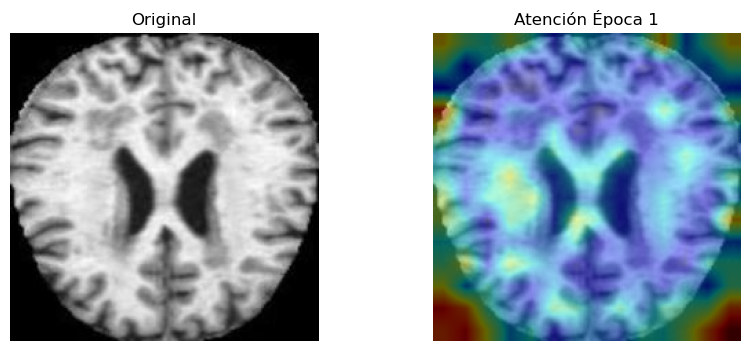

1207/1207 ━━━━━━━━━━━━━━━━━━━━ 42s 26ms/step - accuracy: 0.6393 - f1_macro: 0.6404 - loss: 1.0628 - val_accuracy: 0.7602 - val_f1_macro: 0.7613 - val_loss: 0.7003
Epoch 2/10
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7590 - f1_macro: 0.7630 - loss: 0.6946

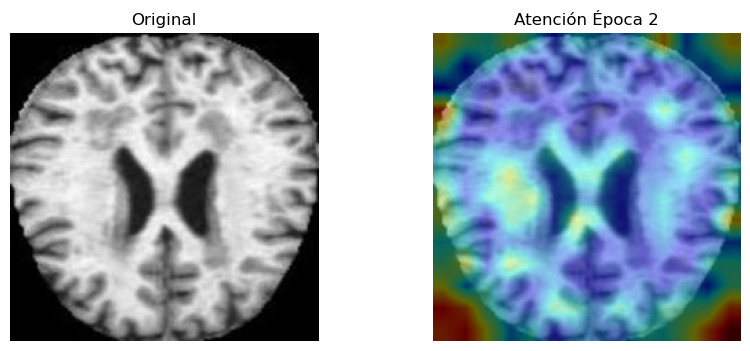

1207/1207 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.7767 - f1_macro: 0.7802 - loss: 0.6444 - val_accuracy: 0.8104 - val_f1_macro: 0.8145 - val_loss: 0.5472
Epoch 3/10
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8115 - f1_macro: 0.8151 - loss: 0.5428

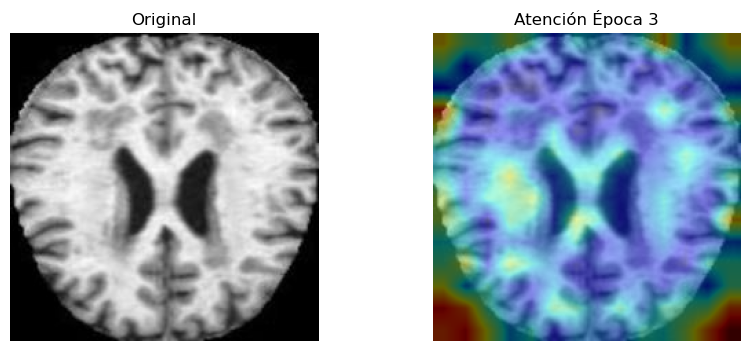

1207/1207 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.8122 - f1_macro: 0.8158 - loss: 0.5310 - val_accuracy: 0.8351 - val_f1_macro: 0.8392 - val_loss: 0.4774
Epoch 4/10
1205/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8329 - f1_macro: 0.8352 - loss: 0.4679

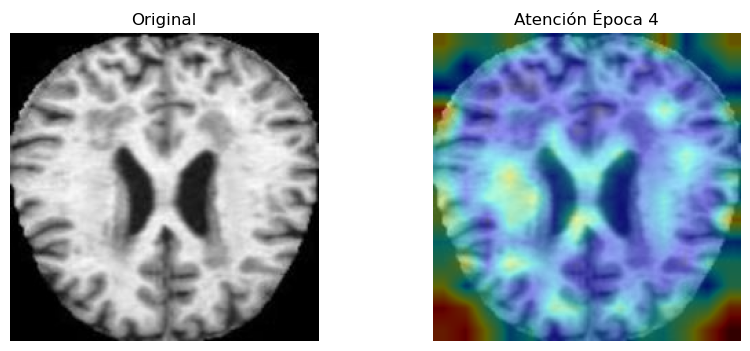

1207/1207 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.8364 - f1_macro: 0.8393 - loss: 0.4626 - val_accuracy: 0.8423 - val_f1_macro: 0.8459 - val_loss: 0.4328
Epoch 5/10
1205/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8522 - f1_macro: 0.8541 - loss: 0.4238

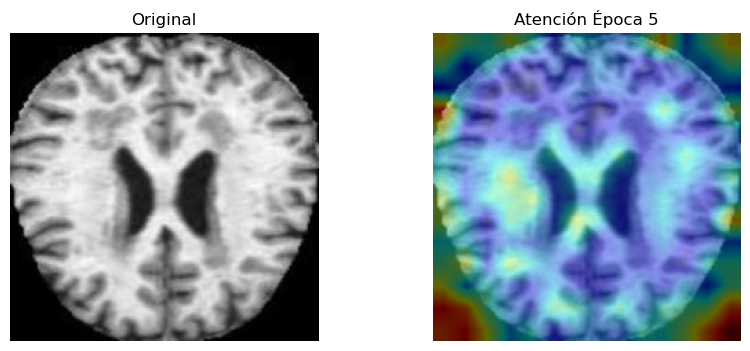

1207/1207 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.8506 - f1_macro: 0.8532 - loss: 0.4207 - val_accuracy: 0.8587 - val_f1_macro: 0.8609 - val_loss: 0.3964
Epoch 6/10
1205/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8590 - f1_macro: 0.8622 - loss: 0.3997

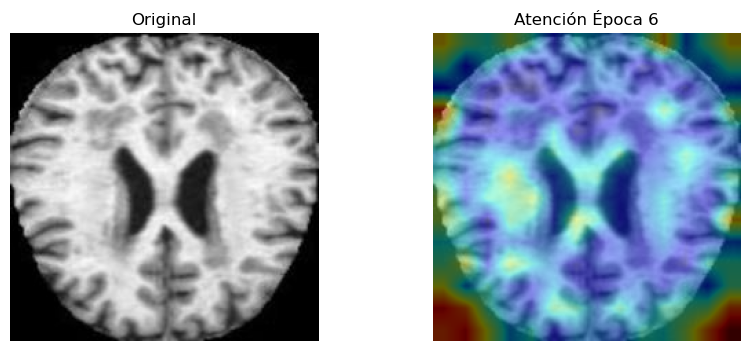

1207/1207 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.8634 - f1_macro: 0.8660 - loss: 0.3891 - val_accuracy: 0.8698 - val_f1_macro: 0.8721 - val_loss: 0.3740
Epoch 7/10
1205/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8692 - f1_macro: 0.8705 - loss: 0.3671

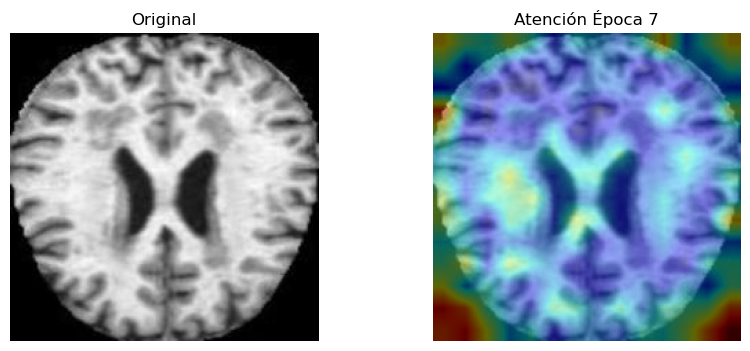

1207/1207 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.8712 - f1_macro: 0.8733 - loss: 0.3619 - val_accuracy: 0.8723 - val_f1_macro: 0.8742 - val_loss: 0.3555
Epoch 8/10
1206/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8764 - f1_macro: 0.8789 - loss: 0.3503

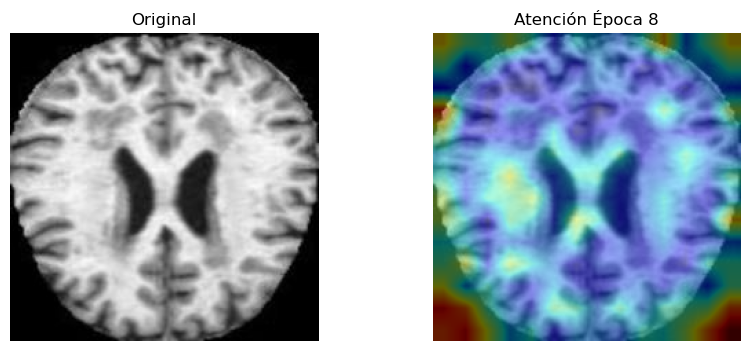

1207/1207 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.8771 - f1_macro: 0.8794 - loss: 0.3411 - val_accuracy: 0.8838 - val_f1_macro: 0.8854 - val_loss: 0.3306
Epoch 9/10
1206/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8886 - f1_macro: 0.8903 - loss: 0.3164

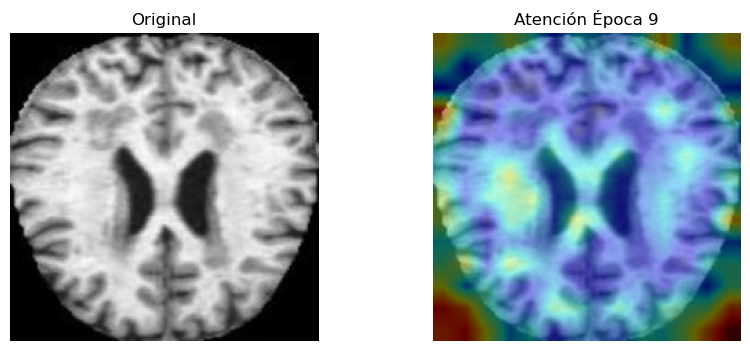

1207/1207 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.8878 - f1_macro: 0.8898 - loss: 0.3185 - val_accuracy: 0.8802 - val_f1_macro: 0.8816 - val_loss: 0.3247
Epoch 10/10
1204/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8877 - f1_macro: 0.8888 - loss: 0.3107

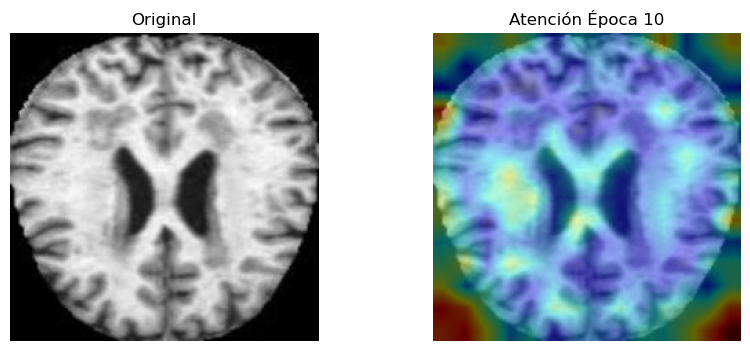

1207/1207 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.8914 - f1_macro: 0.8930 - loss: 0.3046 - val_accuracy: 0.8887 - val_f1_macro: 0.8900 - val_loss: 0.3038
Activando fine-tuning del ViT...
Epoch 1/10
1205/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8943 - f1_macro: 0.8957 - loss: 0.2897

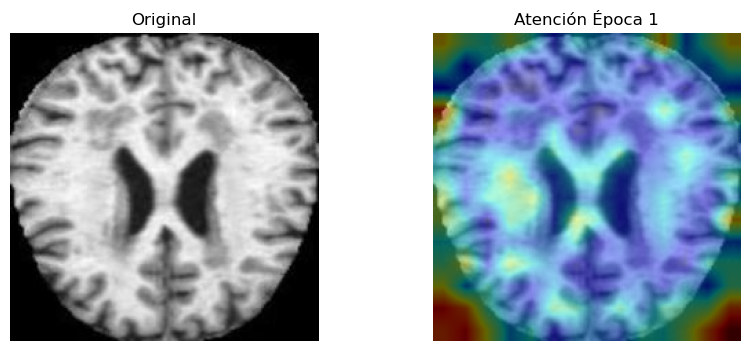

1207/1207 ━━━━━━━━━━━━━━━━━━━━ 39s 24ms/step - accuracy: 0.8963 - f1_macro: 0.8978 - loss: 0.2871 - val_accuracy: 0.8908 - val_f1_macro: 0.8921 - val_loss: 0.3007
Epoch 2/10
1205/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8943 - f1_macro: 0.8956 - loss: 0.2853

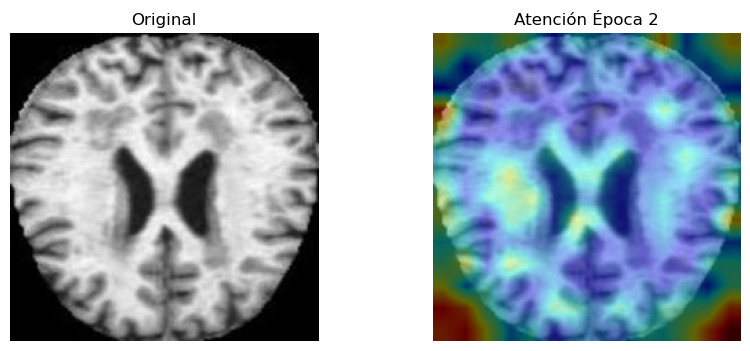

1207/1207 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.8986 - f1_macro: 0.9001 - loss: 0.2828 - val_accuracy: 0.8916 - val_f1_macro: 0.8927 - val_loss: 0.2986
Epoch 3/10
1206/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9038 - f1_macro: 0.9050 - loss: 0.2772

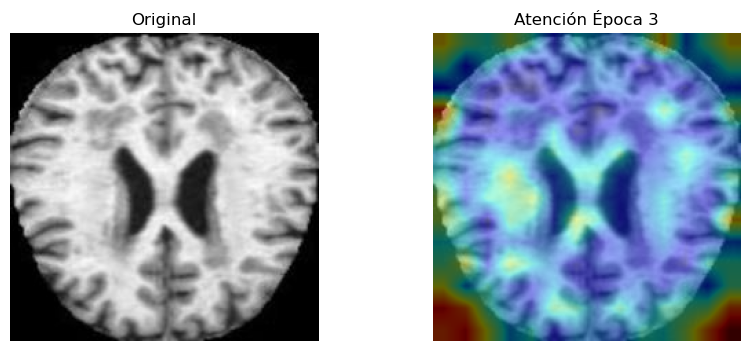

1207/1207 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9000 - f1_macro: 0.9014 - loss: 0.2814 - val_accuracy: 0.8921 - val_f1_macro: 0.8930 - val_loss: 0.2975
Epoch 4/10
1204/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8996 - f1_macro: 0.9012 - loss: 0.2853

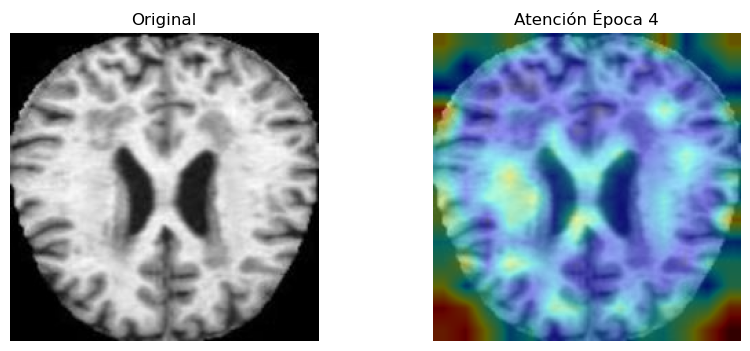

1207/1207 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9014 - f1_macro: 0.9029 - loss: 0.2787 - val_accuracy: 0.8925 - val_f1_macro: 0.8937 - val_loss: 0.2956
Epoch 5/10
1204/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9048 - f1_macro: 0.9065 - loss: 0.2802

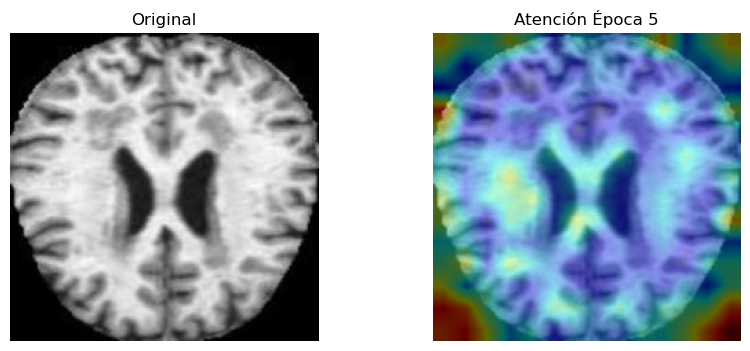

1207/1207 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.9038 - f1_macro: 0.9053 - loss: 0.2780 - val_accuracy: 0.8952 - val_f1_macro: 0.8961 - val_loss: 0.2949
Epoch 6/10
1205/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9009 - f1_macro: 0.9023 - loss: 0.2760

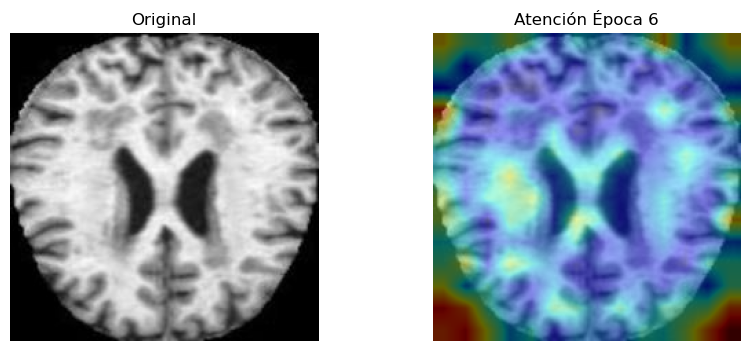

1207/1207 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.9021 - f1_macro: 0.9035 - loss: 0.2760 - val_accuracy: 0.8942 - val_f1_macro: 0.8953 - val_loss: 0.2934
Epoch 7/10
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8981 - f1_macro: 0.8997 - loss: 0.2846

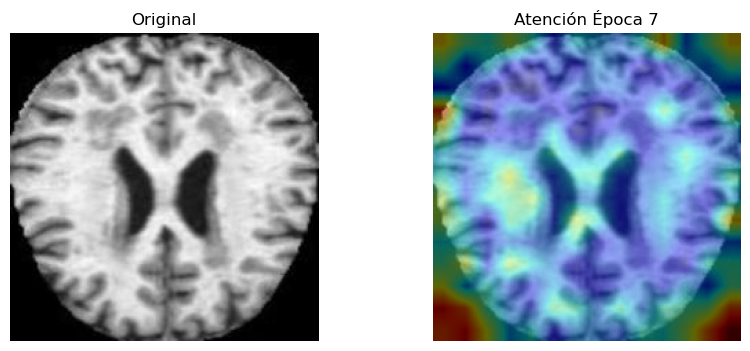

1207/1207 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.9025 - f1_macro: 0.9038 - loss: 0.2759 - val_accuracy: 0.8962 - val_f1_macro: 0.8971 - val_loss: 0.2924
Epoch 8/10
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9055 - f1_macro: 0.9060 - loss: 0.2674

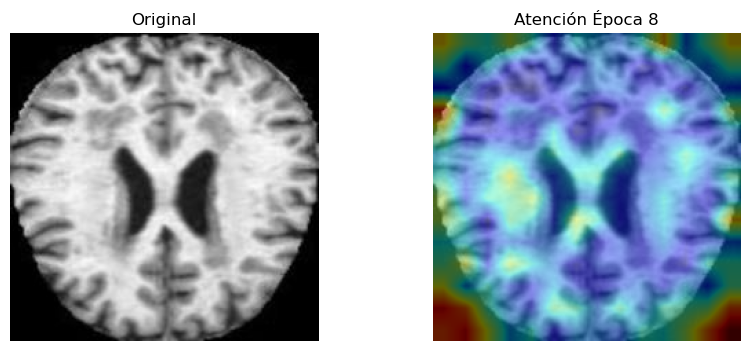

1207/1207 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.9039 - f1_macro: 0.9053 - loss: 0.2737 - val_accuracy: 0.8969 - val_f1_macro: 0.8978 - val_loss: 0.2913
Epoch 9/10
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9057 - f1_macro: 0.9064 - loss: 0.2709

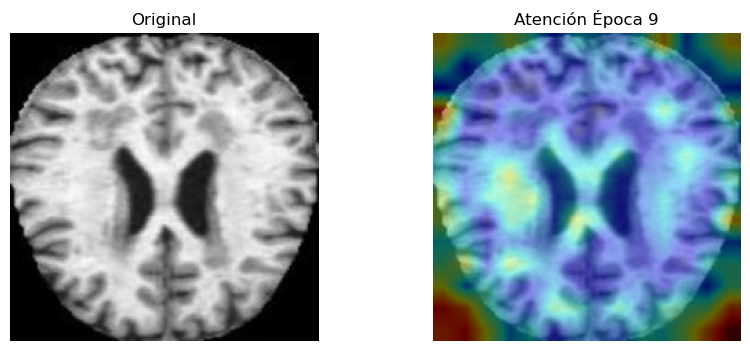

1207/1207 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.9039 - f1_macro: 0.9053 - loss: 0.2725 - val_accuracy: 0.8966 - val_f1_macro: 0.8977 - val_loss: 0.2897
Epoch 10/10
1207/1207 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9049 - f1_macro: 0.9062 - loss: 0.2712

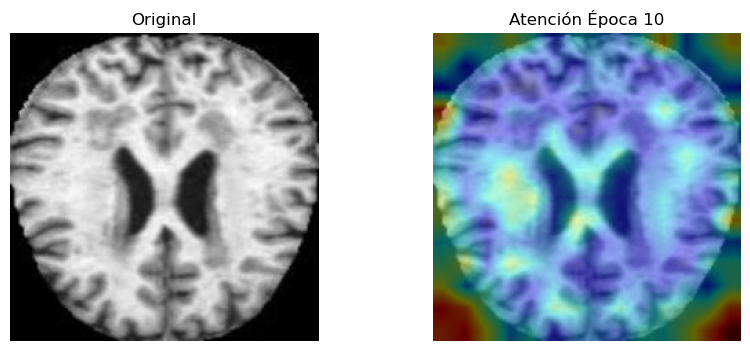

1207/1207 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9053 - f1_macro: 0.9066 - loss: 0.2716 - val_accuracy: 0.8969 - val_f1_macro: 0.8978 - val_loss: 0.2893


In [ ]:
import os
import io
import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, Callback
from sklearn.metrics import confusion_matrix, classification_report
from transformers import TFViTModel, ViTConfig

# ===============================
# CONFIGURACIÓN GENERAL
# ===============================
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 10
NUM_CLASSES = 7
MODEL_NAME = "google/vit-base-patch16-224-in21k"

DATA_DIR = "Data/dataset_vit"
CHECKPOINT_DIR = "checkpoints/checkpoints_vit"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# ===============================
# DATA GENERATORS
# ===============================
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_datagen   = ImageDataGenerator(rescale=1.0 / 255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "train"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "val"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

class_names = list(train_gen.class_indices.keys())

# ============================================================
# CONSTRUCCIÓN DEL MODELO CON ATENCIONES (Explicatividad)
# ============================================================
def build_vit_model(model_name, num_classes):
    print("📌 Cargando backbone de ViT con soporte de atenciones...")

    # Configuración para que el modelo devuelva las matrices de atención
    config = ViTConfig.from_pretrained(model_name, output_attentions=True)
    base_model = TFViTModel.from_pretrained(model_name, from_pt=True, config=config)

    inputs = layers.Input(shape=(224, 224, 3), name="pixel_values_input")
    x = layers.Permute((3, 1, 2))(inputs)

    # Wrapper para extraer last_hidden_state (usado para clasificar)
    def call_vit(tensor):
        return base_model(pixel_values=tensor).last_hidden_state

    x_vit = layers.Lambda(call_vit, name="vit_backbone")(x)
    cls_token = layers.Lambda(lambda v: v[:, 0, :], name="cls_token_extraction")(x_vit)

    x = layers.Dense(256, activation="relu")(cls_token)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="predictions")(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    base_model.trainable = False

    return model, base_model

model, base_vit_layer = build_vit_model(MODEL_NAME, NUM_CLASSES)

# ===============================
# MÉTRICA F1 MACRO (Versión Keras 3)
# ===============================
class F1Macro(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name="f1_macro", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.eps = 1e-7
        self.tp = self.add_weight(name="tp", shape=(num_classes,), initializer="zeros")
        self.fp = self.add_weight(name="fp", shape=(num_classes,), initializer="zeros")
        self.fn = self.add_weight(name="fn", shape=(num_classes,), initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(tf.argmax(y_true, axis=1), tf.int32)
        y_pred = tf.cast(tf.argmax(y_pred, axis=1), tf.int32)
        y_true = tf.one_hot(y_true, self.num_classes)
        y_pred = tf.one_hot(y_pred, self.num_classes)
        self.tp.assign_add(tf.reduce_sum(y_true * y_pred, axis=0))
        self.fp.assign_add(tf.reduce_sum((1 - y_true) * y_pred, axis=0))
        self.fn.assign_add(tf.reduce_sum(y_true * (1 - y_pred), axis=0))

    def result(self):
        precision = self.tp / (self.tp + self.fp + self.eps)
        recall = self.tp / (self.tp + self.fn + self.eps)
        f1 = 2 * precision * recall / (precision + recall + self.eps)
        return tf.reduce_mean(f1)

    def reset_state(self):
        for v in (self.tp, self.fp, self.fn):
            v.assign(tf.zeros_like(v))

# ============================================================
# CALLBACK DE EXPLICATIVIDAD (Attention Rollout)
# ============================================================
class ViTExplainabilityCallback(Callback):
    def __init__(self, sample_image, class_names):
        super().__init__()
        self.sample_image = sample_image
        self.class_names = class_names

    def compute_rollout(self, attentions):
        result = np.eye(attentions[0].shape[-1])
        for attention in attentions:
            # Media de las cabezas de atención (heads)
            attention_heads_prob = np.mean(attention[0], axis=0)
            I = np.eye(attention_heads_prob.shape[-1])
            a = (attention_heads_prob + I) / 2
            a = a / a.sum(axis=-1)
            result = np.matmul(a, result)

        mask = result[0, 1:] # Atenciones del CLS token a los parches
        width = int(np.sqrt(mask.shape[0]))
        mask = mask.reshape(width, width)
        mask = mask / np.max(mask)
        return mask

    def on_epoch_end(self, epoch, logs=None):
        img_tensor = tf.convert_to_tensor(self.sample_image[np.newaxis, ...])
        img_swapped = tf.transpose(img_tensor, [0, 3, 1, 2])
        # Obtenemos atenciones directamente del backbone
        outputs = base_vit_layer(img_swapped, training=False)
        mask = self.compute_rollout([a.numpy() for a in outputs.attentions])

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(self.sample_image)
        plt.title("Original")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        mask_resized = tf.image.resize(mask[..., np.newaxis], (224, 224)).numpy()
        plt.imshow(self.sample_image)
        plt.imshow(mask_resized.squeeze(), cmap='jet', alpha=0.4)
        plt.title(f"Atención Época {epoch+1}")
        plt.axis('off')
        plt.show()

# Preparar una imagen fija para ver la evolución de la atención
sample_x, _ = next(val_gen)
explain_cb = ViTExplainabilityCallback(sample_x[0], class_names)

# ===============================
# COMPILACIÓN Y ENTRENAMIENTO
# ===============================
model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy", F1Macro(NUM_CLASSES)]
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ModelCheckpoint(os.path.join(CHECKPOINT_DIR, "best_vit.h5"), save_best_only=True, monitor="val_accuracy", mode="max"),
    explain_cb
]

print("🚀 Iniciando entrenamiento con Explicatividad...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

print("Activando fine-tuning del ViT...")

for layer in base_vit_layer.layers[-4:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # LR bajo
    loss="categorical_crossentropy",
    metrics=["accuracy", F1Macro(NUM_CLASSES)]
)

fine_tune_epochs = 10

history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=fine_tune_epochs,
    callbacks=callbacks
)
model.save("ViT_final_explicable.h5")

Found 4141 images belonging to 7 classes.
Evaluación en test...
4141/4141 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step

 Classification Report (TEST)
                    precision    recall  f1-score   support

         alzheimer       0.91      0.97      0.94       480
esclerosismultiple       0.90      0.89      0.90       688
            glioma       0.93      0.88      0.91       617
        meningioma       0.86      0.86      0.86       546
         parkinson       0.92      0.91      0.92       681
        pituitaria       0.92      0.95      0.94       511
              sano       0.87      0.87      0.87       618

          accuracy                           0.90      4141
         macro avg       0.90      0.91      0.90      4141
      weighted avg       0.90      0.90      0.90      4141



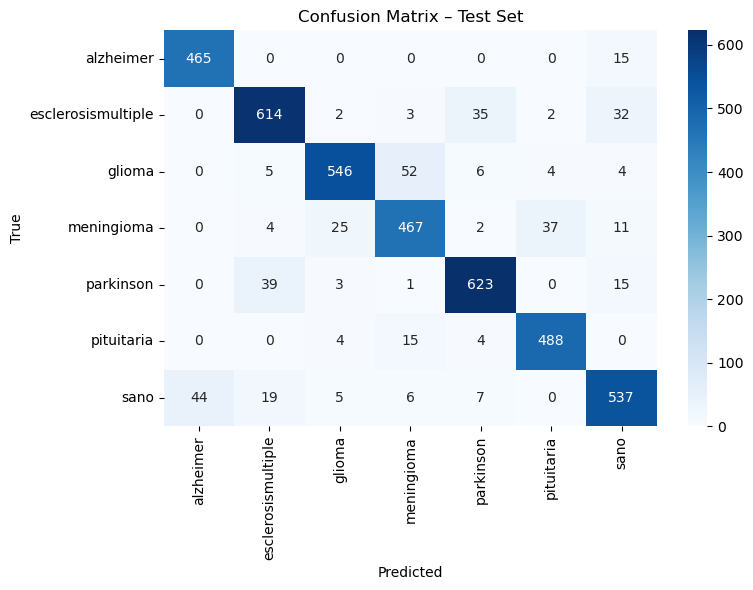

In [ ]:
# ===============================
# TEST DATA GENERATOR
# ===============================
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_gen = test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, "test"),
    target_size=(IMG_SIZE, IMG_SIZE),  # IMPORTANT
    batch_size=1,                      # for per-sample metrics
    class_mode="categorical",
    shuffle=False
)
print("Evaluación en test...")

y_probs_test = model.predict(
    test_gen,
    steps=test_gen.samples,
    verbose=1
)

y_pred_test = np.argmax(y_probs_test, axis=1)
y_true_test = test_gen.classes

print("\n Classification Report (TEST)")
print(
    classification_report(
        y_true_test,
        y_pred_test,
        target_names=class_names,
        zero_division=0
    )
)

import seaborn as sns

cm = confusion_matrix(y_true_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Test Set")
plt.tight_layout()
plt.show()

In [ ]:
import os
import hashlib
from collections import defaultdict

IMG_EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".webp")

def file_hash_md5(path, block_size=2**20):
    h = hashlib.md5()
    with open(path, "rb") as f:
        while True:
            b = f.read(block_size)
            if not b:
                break
            h.update(b)
    return h.hexdigest()

def index_split(split_dir, split_name, index):
    for root, _, files in os.walk(split_dir):
        for f in files:
            if f.lower().endswith(IMG_EXTS):
                full_path = os.path.join(root, f)
                h = file_hash_md5(full_path)
                index[h].append({
                    "split": split_name,
                    "path": full_path
                })

# Diccionario: hash -> lista de archivos
hash_index = defaultdict(list)

index_split(os.path.join(DATA_DIR, "train"), "train", hash_index)
index_split(os.path.join(DATA_DIR, "val"),   "val",   hash_index)
index_split(os.path.join(DATA_DIR, "test"),  "test",  hash_index)


duplicates = {
    h: files
    for h, files in hash_index.items()
    if len(files) > 1
}

print(f"Número total de hashes duplicados: {len(duplicates)}")

def splits_involved(files):
    return sorted(set(f["split"] for f in files))

dup_summary = []

for h, files in duplicates.items():
    dup_summary.append({
        "hash": h,
        "splits": splits_involved(files),
        "n_files": len(files),
        "files": files
    })

# Ejemplos
for d in dup_summary[:5]:
    print("\nHash:", d["hash"])
    print("Splits:", d["splits"])
    for f in d["files"]:
        print(" ", f["split"], "->", f["path"])

import pandas as pd

rows = []
for h, files in duplicates.items():
    for f in files:
        rows.append({
            "hash": h,
            "split": f["split"],
            "path": f["path"]
        })

df_dup = pd.DataFrame(rows)
df_dup.to_csv("duplicados_md5.csv", index=False)

print("Archivo guardado: duplicados_md5.csv")

Número total de hashes duplicados: 64

Hash: eb8b60b7834ab502ef36815b4d7f9813
Splits: ['train']
  train -> Data/dataset_resnet/train/glioma/G_143.jpg
  train -> Data/dataset_resnet/train/glioma/G_545.jpg

Hash: 32a53707babc78a47e63d9359449b23e
Splits: ['train', 'val']
  train -> Data/dataset_resnet/train/glioma/G_534.jpg
  val -> Data/dataset_resnet/val/glioma/G_859.jpg

Hash: 0c6b7b1d8eab60d0cef96f0dac8887d1
Splits: ['test', 'train']
  train -> Data/dataset_resnet/train/glioma/G_523.jpg
  test -> Data/dataset_resnet/test/glioma/G_677.jpg

Hash: 85fa0fa9993918d2d20a0602d21427d4
Splits: ['train', 'val']
  train -> Data/dataset_resnet/train/glioma/G_423.jpg
  val -> Data/dataset_resnet/val/glioma/G_528.jpg

Hash: 4bb63c1edb7410e0e6583cb9b2f2a50d
Splits: ['train', 'val']
  train -> Data/dataset_resnet/train/glioma/G_434.jpg
  val -> Data/dataset_resnet/val/glioma/G_577.jpg
Archivo guardado: duplicados_md5.csv
